In [ ]:
!pip install tb

In [ ]:
!pip install attrdict

In [ ]:
!pip install d3rlpy

In [3]:
import os
import re

import torch
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
import random
import torchvision.utils as vutils
import argparse
import math
import cv2
from matplotlib import pyplot as plt

from torchsummary import summary

from abc import abstractmethod

# Set random seed for reproducibility
seed = 1141
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:8" if (torch.cuda.is_available()) else "cpu")

Random Seed:  1141


In [31]:
train_ds = EdgesDataset(config=config)

dataloader = DataLoader(train_ds, config.parameters.dreamer.batch_size, shuffle=False)

In [41]:
train_ds[0]

(tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[1., 0., 1.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 1., 1., 1.]],
 
         [[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 1., 1., 1.],
       

In [2]:
from encoder import Encoder

In [3]:
model = Encoder(config)

In [6]:
model.to('cuda')

Encoder(
  (_convs): Sequential(
    (0): Conv2dSame(2, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2dSame(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2dSame(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2dSame(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
)

In [2]:
from decoder import Decoder

In [3]:
model = Decoder(config)

In [4]:
model.to('cuda')

Decoder(
  (_conv_transes): Sequential(
    (0): ConvTranspose2dSame(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2dSame(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2dSame(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2dSame(8, 2, kernel_size=(3, 3), stride=(2, 2))
    (10): Sigmoid()
  )
)

In [1]:
from vae import EdgeEntropyVAE

In [3]:
model = EdgeEntropyVAE(config, 0.5)

In [4]:
model

EdgeEntropyVAE(
  (encoder): Encoder(
    (_convs): Sequential(
      (0): Conv2dSame(2, 8, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2dSame(8, 16, kernel_size=(3, 3), stride=(2, 2))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2dSame(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
      (9): Conv2dSame(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): Decoder(
    (_conv_transes): Sequential(
      (0): ConvTranspose2dSame(64, 32, kernel_size=(3, 3), stride=(2, 2))
      (

In [10]:
model.reparameterize(torch.Tensor([0]), torch.Tensor([2]))

tensor([-0.3455])

In [15]:
torch.stack([torch.Tensor([[[0,1],[0,1]]]),torch.Tensor([[[1,1],[1,1]]])]).shape

torch.Size([2, 1, 2, 2])

In [54]:
import re
import cv2

def extract_metadata(fpath):
    
    with open(fpath, 'r') as file:
        info = file.read().rstrip()
        
    info_splited = info.split('_')
    
    timestep = int(info_splited[0])
    reward = int(info_splited[1])
    player_x = int(info_splited[2])
    player_y = int(info_splited[3])
    
    
    movements = info_splited[4].split(';')[:-1]
    
    walk_distance = jump_height = jump_true = 0
    
    for i in range(len(movements)):
        
        movement_list = [int(x) for x in list(movements[i])]
        
        if movement_list[0] == 1:
            walk_distance -= 1
            
        if movement_list[1] == 1:
            walk_distance += 1
        
        if movement_list[2] == 1:
            jump_true = 1
        
        # Если jumpt_true == 0, то не делаем ничего
        if (movement_list[3] == 0) and (jump_true == 1):
            jump_height += 1
        elif (movement_list[3] == 1) and (jump_true == 1):
            jump_height += 1
            jump_true = 0
    
    return timestep, reward, player_x, player_y, walk_distance, jump_height

def load_img(seed, timestep, config):
    
    image_path_1 = config.parameters.edges_dataset.data_root + f'/screenshots0000_{seed}/{timestep}.png'
    image_path_2 = re.sub(r'/screenshots/', r'/screenshots_add/', image_path_1)

    metadata_path = image_path_2[:-3] + 'txt'

    timestep, reward, player_x, player_y, walk_distance, jump_height = extract_metadata(metadata_path)

    if timestep < 7668:
        timestep_next = timestep + 6
        terminal = False
    else:
        terminal = True

    # do your magic here
    # флаг 0 = читаем черно-белое изображение
    img1 = cv2.imread(image_path_1, 0)
    img2 = cv2.imread(image_path_2, 0)

    img_full1 = transform_img(img1, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot, aperture_size=self.config.aperture_size)
    img_full2 = transform_img(img2, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot, aperture_size=self.config.aperture_size)

    img_part1 = transform_img(img1, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot_part, part_size=self.config.part_size, player_x=player_x, player_y=player_y, aperture_size=self.config.aperture_size)
    img_part2 = transform_img(img2, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot_part, part_size=self.config.part_size, player_x=player_x, player_y=player_y, aperture_size=self.config.aperture_size)

    sample_full = cv2.merge([img_full1, img_full2])
    sample_part = cv2.merge([img_part1, img_part2])
    
    return transforms.ToTensor()(sample_full), transforms.ToTensor()(sample_part), timestep, (player_x, player_y), (walk_distance, jump_height), reward, terminal

In [55]:
load_img(359803652, 12, config)

NameError: name 'transform_img' is not defined

In [3]:
train_ds = EdgesDataset(config=config)

dataloader = DataLoader(train_ds, config.parameters.dreamer.batch_size, shuffle=False)

In [4]:
seeds = get_seed_list(config.parameters.edges_dataset.data_root)

In [6]:
observations, actions, rewards, terminals = train_ds.load_episodes(seeds)

In [7]:
print(observations.shape, actions.shape, rewards.shape, terminals.shape)

(12770, 4, 64, 64) (12770, 2) (12770,) (12770,)


In [8]:
from d3rlpy.dataset import MDPDataset

dataset = MDPDataset(observations, actions, rewards, terminals, discrete_action=False)

In [16]:
dataset.dump('MDPdataset_SMF_' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

In [13]:
encoder = Encoder(config).to(device)

In [15]:
observation = buffer.sample(10,10)['observation']
torch.cat([encoder(observation[:,:,0,:,:]),encoder(observation[:,:,1,:,:]),encoder(observation[:,:,2,:,:]),encoder(observation[:,:,3,:,:])],-1)

tensor([[[ 2.3416e-01,  6.0045e-01,  1.3020e+00,  ...,  1.1233e-01,
           1.1233e-01, -8.3058e-04],
         [ 3.3554e-01,  9.1756e-01,  6.0683e-01,  ..., -5.1583e-04,
          -5.1583e-04,  1.5307e-01],
         [-1.5669e-03,  1.1114e+00,  5.8742e-01,  ...,  1.2243e+00,
           2.1191e-01,  2.8043e+00],
         ...,
         [-5.0152e-03,  1.6649e+00,  5.2799e-01,  ..., -6.6693e-03,
          -6.6693e-03, -5.2427e-03],
         [ 3.0595e-01,  1.8360e+00, -1.6966e-03,  ...,  1.9619e+00,
           1.6654e+00,  1.0970e+00],
         [-7.8754e-03,  1.2732e+00, -4.6416e-03,  ..., -2.4606e-02,
          -4.2104e-04, -3.7070e-03]],

        [[ 1.9091e+00,  1.2435e-01,  2.9624e+00,  ...,  1.3341e+00,
          -1.0054e-03,  4.9796e-01],
         [ 1.9683e+00,  8.7909e-01,  4.6802e-01,  ...,  2.9038e+00,
           4.3718e-01,  1.3804e+00],
         [ 1.4281e-01,  7.9280e-01,  2.2420e-01,  ...,  1.7712e+00,
           3.2704e+00,  1.3540e+00],
         ...,
         [-3.9153e-03,  3

In [21]:
encoder(buffer.sample(10,10)['observation'][:,:,3,:,:]).shape

torch.Size([10, 10, 1024])

In [1]:
config_file='config.yml'

import importlib

from dataset import EdgesDataset, get_seed_list
from utils import load_config
from torch.utils.data import DataLoader
import torch
import numpy as np

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

config = load_config(config_file)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from d3rlpy.dataset import MDPDataset

dataset = MDPDataset.load('MDPdataset_SMF_2023-03-24_13-47-05')

In [3]:
observation_shape = dataset.get_observation_shape()
action_size =  dataset.get_action_size()

In [4]:
from buffer import ReplayBuffer

In [5]:
buffer = ReplayBuffer(observation_shape, action_size, config)

In [6]:
for episode in dataset.episodes:
    for transition in episode.transitions:
        buffer.add(transition.observation, transition.action, transition.reward, transition.next_observation, transition.terminal)

In [7]:
buffer.buffer_index

12770

In [8]:
import encoder
importlib.reload(encoder)
from encoder import Encoder

In [9]:
import decoder
importlib.reload(decoder)
from decoder import Decoder

In [10]:
import dreamer
importlib.reload(dreamer)
from dreamer import Dreamer

In [11]:
log_dir = (
        "runs/"
        + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        + "_"
        + config.operation.log_dir
    )
writer = SummaryWriter(log_dir)
device = config.operation.device
obs_shape = dataset.get_observation_shape()
discrete_action_bool = False 
action_size = dataset.get_action_size()

agent = Dreamer(
            obs_shape, discrete_action_bool, action_size, writer, device, config, verbose=False
        )

In [ ]:
agent.train_offline(buffer)

0.09088746458292007 0.031418003141880035 0.03
0.09707493335008621 0.03202668949961662 0.030095577239990234
0.09116777777671814 0.027922986075282097 0.03
0.09040166437625885 0.028460726141929626 0.03
0.08119543641805649 0.027560554444789886 0.03
0.08473160862922668 0.030006855726242065 0.03
0.09141581505537033 0.028504125773906708 0.03
0.0956513062119484 0.032256901264190674 0.03
0.08457784354686737 0.029300568625330925 0.03
0.09168215095996857 0.02975388616323471 0.03
0.09309519082307816 0.03002113848924637 0.03
0.09637472778558731 0.029682453721761703 0.03
0.09034552425146103 0.02973584085702896 0.03
0.08097394555807114 0.028467202559113503 0.03
0.09291854500770569 0.030713539570569992 0.03
0.09354812651872635 0.03222760930657387 0.03
0.08520237356424332 0.03100491687655449 0.03
0.10312369465827942 0.03078961744904518 0.030374839305877685
0.07966496795415878 0.02784649468958378 0.03
0.09606251120567322 0.03335146605968475 0.03
0.08489017188549042 0.028880920261144638 0.03
0.0950202494

0.08445583283901215 0.03044593147933483 0.03
0.08545564115047455 0.03147610276937485 0.03
0.09300940483808517 0.031132210046052933 0.03
0.08853026479482651 0.0291236974298954 0.03
0.09060348570346832 0.030330805107951164 0.03
0.10300905257463455 0.030867237597703934 0.03
0.0907893180847168 0.03050966002047062 0.03
0.08919773995876312 0.03044024109840393 0.03
0.08317192643880844 0.027903156355023384 0.03
0.08671657741069794 0.02828032337129116 0.03
0.08516671508550644 0.02884167805314064 0.03
0.08878987282514572 0.031309641897678375 0.03
0.09097858518362045 0.03047955594956875 0.03
0.09327499568462372 0.031743235886096954 0.03
0.093147873878479 0.03126361966133118 0.03
0.08970008790493011 0.028314579278230667 0.03
0.0874418392777443 0.029785186052322388 0.03
0.09211810678243637 0.030454106628894806 0.03
0.08160098642110825 0.02981652319431305 0.03
0.08947912603616714 0.028160372748970985 0.03
0.08166812360286713 0.027492064982652664 0.03
0.09141603857278824 0.030151955783367157 0.03
0.0

0.0948069617152214 0.029708676040172577 0.03
0.08895115554332733 0.02940710261464119 0.03
0.09053175896406174 0.031793013215065 0.03
0.083512082695961 0.02927185781300068 0.03
0.09854181110858917 0.030994370579719543 0.03
0.09999385476112366 0.0319388248026371 0.03
0.08409514278173447 0.02852441556751728 0.03
0.09527520090341568 0.030990883708000183 0.03
0.09309453517198563 0.029777685180306435 0.03
0.09914252161979675 0.03152422234416008 0.03
0.08932539075613022 0.03162685036659241 0.03
0.09618446975946426 0.03221377730369568 0.03
0.08992137014865875 0.027461180463433266 0.03
0.09538517147302628 0.032022807747125626 0.03
0.08561234176158905 0.028671029955148697 0.03
0.08982457965612411 0.029881412163376808 0.03
0.0985642746090889 0.034285303205251694 0.03
0.08947580307722092 0.02954702079296112 0.03
0.08772782236337662 0.031052779406309128 0.03
0.0872727483510971 0.028384016826748848 0.03
0.08660577237606049 0.031259339302778244 0.03
0.09293860197067261 0.032973721623420715 0.03
0.092

0.09487954527139664 0.030596503987908363 0.03
0.08422236889600754 0.02832595817744732 0.03
0.09860128909349442 0.03172433376312256 0.03
0.09126345068216324 0.03046041913330555 0.03
0.08023735135793686 0.026865419000387192 0.03
0.0857769101858139 0.029295561835169792 0.03
0.08773685246706009 0.03040810488164425 0.03
0.09360770136117935 0.03193897381424904 0.03
0.08954814076423645 0.029684126377105713 0.03
0.09867360442876816 0.03167189285159111 0.03
0.09324976056814194 0.03183736652135849 0.03
0.09334953129291534 0.03156152367591858 0.03
0.09297813475131989 0.030311498790979385 0.03018867492675781
0.08914798498153687 0.02991827204823494 0.03
0.09433823823928833 0.02921910397708416 0.03
0.08804786950349808 0.031180551275610924 0.03
0.08505752682685852 0.028732098639011383 0.03
0.08262602984905243 0.02783537097275257 0.03
0.09461546689271927 0.028822587803006172 0.03
0.09856300055980682 0.03167128562927246 0.03
0.09123474359512329 0.03131544217467308 0.03
0.09607979655265808 0.03137523680

0.09079114347696304 0.03018619492650032 0.03
0.0900566428899765 0.027498120442032814 0.03
0.08902328461408615 0.02902197651565075 0.03
0.09399077296257019 0.02959638088941574 0.03
0.08468981087207794 0.02970011532306671 0.03
0.08649285137653351 0.03066297248005867 0.03
0.09537810832262039 0.03208688646554947 0.03
0.08739780634641647 0.03030972369015217 0.03
0.09843023866415024 0.033450961112976074 0.03
0.09168116003274918 0.03201282396912575 0.03
0.08424194157123566 0.02845492959022522 0.03
0.0880059227347374 0.031917598098516464 0.03
0.09202137589454651 0.02937334030866623 0.03
0.08748284727334976 0.030571969226002693 0.03
0.0873696431517601 0.028734378516674042 0.03
0.09566326439380646 0.031233957037329674 0.03
0.09570726752281189 0.03108038380742073 0.03
0.08895707875490189 0.028341107070446014 0.03
0.08808583766222 0.02837986871600151 0.03
0.08886639028787613 0.02932032383978367 0.03
0.08174940198659897 0.030199823901057243 0.03
0.09783386439085007 0.0317528210580349 0.03
0.0972969

0.08392561227083206 0.029725024476647377 0.03
0.09463363885879517 0.03178618475794792 0.03
0.08800991624593735 0.03132956847548485 0.03
0.09582072496414185 0.030945902690291405 0.03
0.08136234432458878 0.027164218947291374 0.03
0.09617795795202255 0.0313105434179306 0.03
0.0847523957490921 0.02889270707964897 0.03
0.08423683047294617 0.027466587722301483 0.03
0.08961621671915054 0.03052373044192791 0.03
0.08001711219549179 0.027722282335162163 0.03
0.12014779448509216 0.03557814285159111 0.03
0.08641992509365082 0.028246833011507988 0.03
0.09680373966693878 0.031461648643016815 0.03
0.08862432837486267 0.02816358581185341 0.03
0.08965594321489334 0.030631301924586296 0.03
0.09227205812931061 0.03082800656557083 0.03
0.09446742385625839 0.031801316887140274 0.03
0.0985136330127716 0.0316661074757576 0.03
0.08848541975021362 0.031148359179496765 0.03
0.09457840025424957 0.030265916138887405 0.03
0.08921635895967484 0.029250724241137505 0.03
0.09619129449129105 0.030349072068929672 0.03
0

0.09792819619178772 0.03390108421444893 0.0305954647064209
0.09016832709312439 0.029982350766658783 0.03
0.09347078204154968 0.030914099887013435 0.03
0.08645407110452652 0.027687469497323036 0.03
0.09314907342195511 0.030570421367883682 0.03
0.08512509614229202 0.028610600158572197 0.03
0.08049194514751434 0.03018394485116005 0.03
0.0932130217552185 0.03207333758473396 0.03
0.09052307903766632 0.031084751710295677 0.03
0.08396998792886734 0.029638562351465225 0.03
0.09682122617959976 0.03186660632491112 0.03
0.092633455991745 0.030591590330004692 0.03
0.084209144115448 0.030442608520388603 0.03
0.08059077709913254 0.027537941932678223 0.03
0.08924873173236847 0.03120628371834755 0.03
0.08703271299600601 0.02756032720208168 0.03
0.08990881592035294 0.029802344739437103 0.03
0.09169751405715942 0.030033176764845848 0.03
0.09030736237764359 0.029589053243398666 0.03
0.09456316381692886 0.03150369971990585 0.03
0.09276946634054184 0.029384413734078407 0.03
0.08411330729722977 0.0296454839

0.09106005728244781 0.030177917331457138 0.03
0.08656534552574158 0.02878463640809059 0.03
0.09367483109235764 0.03145386651158333 0.030080788135528565
0.10144534707069397 0.03129548951983452 0.03
0.08949791640043259 0.02922489121556282 0.03
0.09374018758535385 0.03037075512111187 0.03
0.09476197510957718 0.030663566663861275 0.03
0.08700215071439743 0.03205516189336777 0.03
0.09004980325698853 0.031225668266415596 0.03
0.09356247633695602 0.03136031702160835 0.03
0.09455205500125885 0.029725583270192146 0.03
0.08672584593296051 0.03009774349629879 0.03
0.10760435461997986 0.03562006726861 0.030041630268096923
0.08897227793931961 0.02955320104956627 0.03
0.08336755633354187 0.029336940497159958 0.03
0.09112036228179932 0.02909703366458416 0.03
0.08555810898542404 0.02962520346045494 0.03
0.10170670598745346 0.03143121302127838 0.03
0.0954766497015953 0.03192019462585449 0.03
0.08276767283678055 0.028540989384055138 0.03
0.1041378527879715 0.033325325697660446 0.03
0.09399055689573288 0

0.08936408162117004 0.032879337668418884 0.03
0.09010273218154907 0.030810251832008362 0.03
0.09903985261917114 0.0327952578663826 0.03
0.08676117658615112 0.029661674052476883 0.03
0.0969017818570137 0.030327502638101578 0.03
0.09633459895849228 0.0323508195579052 0.03
0.1119142696261406 0.03450560197234154 0.030596954822540285
0.09991109371185303 0.03363824635744095 0.03
0.09306159615516663 0.030657576397061348 0.03
0.10408211499452591 0.033207837492227554 0.03
0.09330933541059494 0.029520928859710693 0.03
0.08918909728527069 0.029944822192192078 0.03
0.08710084855556488 0.029237251728773117 0.03
0.08363809436559677 0.02932770922780037 0.03
0.08476972579956055 0.027611803263425827 0.03
0.08526268601417542 0.0289241224527359 0.03
0.09120027720928192 0.031141342595219612 0.03
0.1002095639705658 0.029958371073007584 0.03
0.09134037792682648 0.029733959585428238 0.03
0.09022387117147446 0.0313480906188488 0.03
0.09073588997125626 0.0282175000756979 0.03
0.09640896320343018 0.030480379238

0.08698258548974991 0.02738352119922638 0.03
0.0981544703245163 0.031088629737496376 0.03
0.084467314183712 0.030161676928400993 0.03
0.09924107044935226 0.03183610737323761 0.03
0.09732625633478165 0.02930506505072117 0.03
0.09805919229984283 0.03400155156850815 0.03
0.09618104994297028 0.030703803524374962 0.03
0.09352373331785202 0.03138405457139015 0.03
0.09568431228399277 0.032409269362688065 0.03
0.08881258219480515 0.02967406064271927 0.03
0.0970860943198204 0.02939552254974842 0.03
0.0955037996172905 0.030992232263088226 0.03
0.0817951112985611 0.027800194919109344 0.03
0.09792249649763107 0.030368993058800697 0.03
0.08411049097776413 0.0287544634193182 0.03
0.08944256603717804 0.028144529089331627 0.03
0.09181470423936844 0.030922643840312958 0.03
0.08041441440582275 0.025846730917692184 0.03
0.08840614557266235 0.030195796862244606 0.03
0.10894094407558441 0.0348038449883461 0.03024401903152466
0.0865723192691803 0.029581483453512192 0.03
0.09338727593421936 0.030066596344113

0.0903511494398117 0.03269859775900841 0.03
0.08978521823883057 0.030550040304660797 0.03
0.08897989243268967 0.029554245993494987 0.03
0.09483695775270462 0.03379134461283684 0.03
0.09882943332195282 0.03435789421200752 0.03
0.0873517245054245 0.029470354318618774 0.03
0.09291300922632217 0.030982758849859238 0.03
0.08706282079219818 0.031515933573246 0.03
0.08806038647890091 0.030331434682011604 0.03
0.09416563808917999 0.03171101212501526 0.03
0.08852502703666687 0.029678234830498695 0.03
0.09094014018774033 0.031159644946455956 0.03
0.09871115535497665 0.031344469636678696 0.03
0.08192231506109238 0.027114596217870712 0.03
0.08994905650615692 0.030201366171240807 0.03
0.08399531245231628 0.026819482445716858 0.03
0.08920204639434814 0.030825363472104073 0.03
0.08368733525276184 0.027788152918219566 0.03
0.08869826048612595 0.02958722971379757 0.03
0.09004803001880646 0.026645762845873833 0.03
0.09067200869321823 0.031053245067596436 0.03
0.08823089301586151 0.02992708422243595 0.03

0.09753156453371048 0.031607381999492645 0.03
0.08794380724430084 0.03266336768865585 0.03
0.08156022429466248 0.028102705255150795 0.03
0.09728474169969559 0.032357655465602875 0.03028345346450806
0.09513494372367859 0.03106316737830639 0.03
0.09755247086286545 0.029843388125300407 0.03
0.08204711973667145 0.02613406628370285 0.03
0.09766119718551636 0.03129178658127785 0.03
0.10852201282978058 0.03106806054711342 0.03
0.09771387279033661 0.03371065855026245 0.03
0.09784333407878876 0.032078780233860016 0.03
0.09563912451267242 0.03075147606432438 0.03
0.08521579951047897 0.029486415907740593 0.03
0.09176167100667953 0.02956380508840084 0.03
0.08566867560148239 0.028693940490484238 0.03
0.09426204860210419 0.029715722426772118 0.03
0.07999640703201294 0.02970188297331333 0.03
0.0865214467048645 0.027911033481359482 0.03
0.0973307341337204 0.03185184299945831 0.03
0.0915575698018074 0.0310882069170475 0.03
0.09676043689250946 0.031088659539818764 0.03237190723419189
0.08495434373617172

0.0899420902132988 0.028105612844228745 0.03
0.09472481906414032 0.03308818116784096 0.03
0.08352802693843842 0.03139207512140274 0.030095632076263427
0.09157252311706543 0.028969507664442062 0.03
0.09491478651762009 0.03133883699774742 0.03
0.08123219013214111 0.026048913598060608 0.03
0.08353579789400101 0.02921406365931034 0.03
0.08896556496620178 0.028422798961400986 0.03
0.0884699672460556 0.02822977304458618 0.03
0.09195106476545334 0.028792476281523705 0.03
0.0918547734618187 0.03152933344244957 0.03
0.0886635035276413 0.02967642806470394 0.03
0.10049426555633545 0.033935174345970154 0.03
0.09333759546279907 0.030124859884381294 0.03
0.07859836518764496 0.027717532590031624 0.03
0.09341111034154892 0.03026236966252327 0.03
0.09471321851015091 0.03126095235347748 0.03
0.09206128865480423 0.031274061650037766 0.03
0.09741911292076111 0.031805459409952164 0.03006854295730591
0.09276240319013596 0.029890719801187515 0.03
0.08792199939489365 0.028689302504062653 0.03
0.09631453454494

0.09065906703472137 0.0282540675252676 0.03
0.09199552237987518 0.03155567869544029 0.03
0.08426456153392792 0.03013662062585354 0.03
0.10452011227607727 0.031088339164853096 0.03
0.09287824481725693 0.02995576523244381 0.03
0.08480247110128403 0.029315238818526268 0.03
0.08688680082559586 0.029527800157666206 0.03
0.09114036709070206 0.029356876388192177 0.03
0.09550496935844421 0.031150594353675842 0.03
0.08256527036428452 0.027965109795331955 0.03
0.08864109218120575 0.027573950588703156 0.03
0.08436262607574463 0.02886340208351612 0.03
0.0925273671746254 0.029675602912902832 0.03
0.08441347628831863 0.028114160522818565 0.03
0.09002000093460083 0.02791287750005722 0.03
0.07946183532476425 0.028309473767876625 0.03
0.08242084085941315 0.0293351411819458 0.03
0.08519227057695389 0.027480918914079666 0.03
0.08581624925136566 0.030331013724207878 0.03
0.09057383239269257 0.031014829874038696 0.030159263610839846
0.11010066419839859 0.03155308961868286 0.03
0.08902158588171005 0.0298099

0.0879574567079544 0.029040683060884476 0.03
0.10147631168365479 0.03314812853932381 0.03
0.08614693582057953 0.027899235486984253 0.03
0.08888489007949829 0.02970689721405506 0.03
0.09360987693071365 0.03220858797430992 0.03
0.0880654975771904 0.029319975525140762 0.03
0.09931571036577225 0.031633198261260986 0.03
0.09541867673397064 0.030480269342660904 0.03
0.08382339775562286 0.029410487040877342 0.03
0.08978930860757828 0.02981838397681713 0.03
0.09249799698591232 0.029824135825037956 0.03
0.0892229974269867 0.03044869191944599 0.03
0.09339269250631332 0.02945651113986969 0.03
0.09336107224225998 0.030942020937800407 0.03
0.09697620570659637 0.031004248186945915 0.03
0.09070785343647003 0.027961496263742447 0.03
0.097392737865448 0.031774695962667465 0.03
0.0914924368262291 0.03000415861606598 0.03
0.0850076824426651 0.030057454481720924 0.03
0.08406833559274673 0.027891771867871284 0.03
0.08578670769929886 0.02827223390340805 0.03
0.0875895544886589 0.029670927673578262 0.03
0.09

0.08822315186262131 0.030146900564432144 0.03
0.09177237004041672 0.03036576695740223 0.03
0.09511903673410416 0.032600488513708115 0.03
0.09288672357797623 0.031809642910957336 0.03
0.09051503986120224 0.030979787930846214 0.03
0.08645462244749069 0.028686411678791046 0.03
0.08252457529306412 0.027469811961054802 0.03
0.08620672672986984 0.03058157116174698 0.03
0.08929894864559174 0.03008807636797428 0.03
0.09388582408428192 0.03313920274376869 0.03
0.0989985242486 0.030680274590849876 0.03
0.09383295476436615 0.031186964362859726 0.03
0.0928935557603836 0.029275234788656235 0.03
0.08086923509836197 0.027666261419653893 0.03
0.09538083523511887 0.032528627663850784 0.03
0.08817917853593826 0.030143018811941147 0.03
0.08447425812482834 0.029109666123986244 0.03
0.09712556004524231 0.03161843866109848 0.03
0.09251917898654938 0.03000633232295513 0.03
0.08532553166151047 0.027908900752663612 0.03
0.08614078164100647 0.03059425950050354 0.03
0.10240034013986588 0.03153236210346222 0.03
0

0.09862855076789856 0.03261543810367584 0.03
0.09850707650184631 0.03363515064120293 0.03
0.09087444096803665 0.031210925430059433 0.03
0.08565903455018997 0.028970107436180115 0.03
0.09784670919179916 0.02999901957809925 0.03
0.09854783862829208 0.030271312221884727 0.03
0.09491666406393051 0.029771270230412483 0.03
0.10148778557777405 0.03171326592564583 0.03
0.09330479055643082 0.02960304543375969 0.03
0.0981440320611 0.031642597168684006 0.03
0.0901232436299324 0.030933739617466927 0.03
0.089799664914608 0.027575122192502022 0.03
0.0831579715013504 0.027646822854876518 0.03
0.0986182689666748 0.031287431716918945 0.03
0.08653947710990906 0.03034626506268978 0.03
0.09555776417255402 0.03235943615436554 0.03005715608596802
0.08420931547880173 0.029274092987179756 0.03
0.09623345732688904 0.029272250831127167 0.03
0.0837320014834404 0.027381515130400658 0.03
0.09325903654098511 0.030092457309365273 0.03
0.08810878545045853 0.0309626255184412 0.03
0.08815343677997589 0.0293944031000137

0.09030549973249435 0.03172381967306137 0.03
0.08559919148683548 0.03086291067302227 0.03
0.08895546197891235 0.028956608846783638 0.03
0.08977372199296951 0.02924310974776745 0.03
0.09823780506849289 0.029872193932533264 0.030066349506378175
0.08495528250932693 0.02825929969549179 0.03
0.09281191229820251 0.02966819703578949 0.03
0.09815087169408798 0.030019162222743034 0.03
0.08922435343265533 0.029982807114720345 0.03
0.08827195316553116 0.028899187222123146 0.03
0.09428413212299347 0.030907951295375824 0.03
0.08499883860349655 0.029146358370780945 0.03
0.09230338037014008 0.030673833563923836 0.03
0.09645664691925049 0.031958021223545074 0.03
0.09304609149694443 0.030467785894870758 0.03
0.08920810371637344 0.03160593658685684 0.03
0.08927071839570999 0.02763473242521286 0.03
0.09275633841753006 0.03154323995113373 0.03
0.09267566353082657 0.031628213822841644 0.03
0.08946133404970169 0.030501477420330048 0.03
0.08773572742938995 0.030025754123926163 0.03
0.0959462821483612 0.03064

0.09256734699010849 0.030932238325476646 0.03
0.09524847567081451 0.03149721026420593 0.03
0.08171821385622025 0.027879169210791588 0.03
0.09903884679079056 0.031257111579179764 0.03
0.09799610823392868 0.031028373166918755 0.03
0.0897320955991745 0.02979116700589657 0.03
0.07675613462924957 0.02831428498029709 0.03
0.0880160704255104 0.02973097376525402 0.03
0.0942477211356163 0.029095066711306572 0.03
0.0878419354557991 0.032684605568647385 0.03
0.09448213875293732 0.02963493950664997 0.030125572681427
0.09639476984739304 0.031126271933317184 0.03
0.09684807807207108 0.03231465443968773 0.03
0.09145049750804901 0.030726028606295586 0.03
0.08964721113443375 0.028816064819693565 0.03
0.09169180691242218 0.02944953367114067 0.03
0.09031864255666733 0.03088200092315674 0.03
0.09041984379291534 0.028550326824188232 0.03
0.103878453373909 0.03387819975614548 0.03
0.08456281572580338 0.030911091715097427 0.03
0.09215526282787323 0.03076825849711895 0.03
0.09185764938592911 0.029359735548496

0.09484661370515823 0.03251783177256584 0.03
0.09023973345756531 0.027906332165002823 0.03
0.08963528275489807 0.027809415012598038 0.03
0.09441255778074265 0.03350776806473732 0.03065420150756836
0.09332673251628876 0.02998311072587967 0.03
0.08927160501480103 0.03232327476143837 0.03
0.1018562987446785 0.031726181507110596 0.03
0.0946420282125473 0.03029984049499035 0.03
0.09374691545963287 0.02944757789373398 0.03
0.09365805238485336 0.031486839056015015 0.03
0.09076802432537079 0.02937108464539051 0.03
0.09104035049676895 0.029179610311985016 0.03
0.08822105079889297 0.03177875652909279 0.03
0.0922100841999054 0.03033991903066635 0.03
0.08253701031208038 0.031171876937150955 0.03
0.08325110375881195 0.027931686490774155 0.03
0.08392265439033508 0.028144126757979393 0.03
0.08733634650707245 0.028166979551315308 0.03
0.08465159684419632 0.029334085062146187 0.03
0.08335649222135544 0.027762271463871002 0.03
0.09224997460842133 0.03183290734887123 0.03
0.09717121720314026 0.0303744059

0.08295219391584396 0.028567466884851456 0.03
0.08734561502933502 0.029731621965765953 0.03
0.09774214774370193 0.03128204494714737 0.03
0.0796540305018425 0.02567685768008232 0.03
0.09211768209934235 0.028736572712659836 0.03
0.08458627015352249 0.02806163765490055 0.03
0.0805450901389122 0.027551688253879547 0.03
0.07999097555875778 0.027919573709368706 0.03
0.09716251492500305 0.03168680518865585 0.03
0.08418495208024979 0.02955164760351181 0.03
0.09479799121618271 0.0289845522493124 0.03
0.10020029544830322 0.032506123185157776 0.03
0.09211524575948715 0.03142133355140686 0.03
0.09297716617584229 0.030455444008111954 0.03
0.08940649032592773 0.027431119233369827 0.03
0.10384199768304825 0.03358765318989754 0.03
0.09669540077447891 0.02925330586731434 0.03
0.0912303477525711 0.02790946327149868 0.03006340026855469
0.08884625881910324 0.029345132410526276 0.03
0.09159494936466217 0.029313430190086365 0.03
0.0876101478934288 0.02851947955787182 0.03
0.09660547226667404 0.0306599251925

0.10073225945234299 0.03047843649983406 0.03
0.08878476917743683 0.03261249139904976 0.03
0.08636675029993057 0.029451783746480942 0.03
0.08444349467754364 0.027304960414767265 0.03
0.0942496731877327 0.0309930220246315 0.03
0.09024392813444138 0.027203084900975227 0.03
0.09378176182508469 0.029995737597346306 0.03
0.0887550637125969 0.0288353580981493 0.03
0.09110288321971893 0.03045503795146942 0.03
0.08355963230133057 0.02680768072605133 0.03
0.08792950212955475 0.03077371045947075 0.03
0.09287010878324509 0.028941230848431587 0.03
0.09101604670286179 0.028110705316066742 0.030038468837738037
0.08343411237001419 0.027516288682818413 0.03
0.08507877588272095 0.02777918614447117 0.03
0.09308622777462006 0.02964463084936142 0.03
0.08477666229009628 0.02745250053703785 0.03
0.08227107673883438 0.026228658854961395 0.03
0.08594819903373718 0.02810485288500786 0.03
0.08275695890188217 0.029784156009554863 0.03
0.09149906784296036 0.02895844541490078 0.03
0.09610355645418167 0.032243903726

0.09176169335842133 0.030455809086561203 0.03
0.08834847807884216 0.027552122250199318 0.03
0.0810936838388443 0.02792610600590706 0.03
0.09603896737098694 0.03099479153752327 0.03
0.09198273718357086 0.029560552909970284 0.03
0.08918451517820358 0.031911347061395645 0.03
0.09442722797393799 0.03073868341743946 0.03
0.0839637741446495 0.026856280863285065 0.03
0.09301343560218811 0.029254203662276268 0.03
0.09490106999874115 0.03305104002356529 0.03
0.09371662884950638 0.028907600790262222 0.03
0.08808720111846924 0.02993398904800415 0.03
0.08945238590240479 0.02910105511546135 0.03
0.09858803451061249 0.033223167061805725 0.03
0.08952965587377548 0.028365211561322212 0.03
0.09179862588644028 0.03020753338932991 0.03
0.08453477174043655 0.029464004561305046 0.03
0.08960536122322083 0.03195486217737198 0.03
0.08709339052438736 0.028313500806689262 0.03
0.09538299590349197 0.032103851437568665 0.03
0.097196564078331 0.028842467814683914 0.03
0.09293271601200104 0.030755020678043365 0.03


0.09109853953123093 0.03065221756696701 0.03
0.10444924235343933 0.032843369990587234 0.030339281558990478
0.08641531318426132 0.02900502271950245 0.03
0.09723901003599167 0.02966802380979061 0.03
0.0805431678891182 0.029312316328287125 0.03
0.08279123902320862 0.02585282362997532 0.03
0.09067735075950623 0.03077101521193981 0.03
0.09345795959234238 0.029619421809911728 0.03
0.09557964652776718 0.03304579108953476 0.03
0.0927039235830307 0.030596476048231125 0.03
0.08329233527183533 0.027451084926724434 0.03
0.09749995172023773 0.03099929727613926 0.03
0.0865212008357048 0.030417844653129578 0.03
0.08413804322481155 0.02760627120733261 0.03
0.08676444739103317 0.027415519580245018 0.03
0.07969153672456741 0.026689082384109497 0.03
0.09280391037464142 0.03267069533467293 0.030211832523345947
0.0968010351061821 0.03416541963815689 0.03
0.09600166231393814 0.031374674290418625 0.03
0.08757618069648743 0.028707733377814293 0.03
0.08621935546398163 0.029187297448515892 0.03
0.08247808367013

0.0891403928399086 0.02832815609872341 0.03
0.08372477442026138 0.03101871721446514 0.03
0.08922713249921799 0.03142138943076134 0.03
0.0903015062212944 0.02963045984506607 0.03
0.08429618924856186 0.026962922886013985 0.03
0.08970993012189865 0.02756124548614025 0.03
0.0876149982213974 0.02980666607618332 0.03
0.08844567090272903 0.029348962008953094 0.03
0.09586947411298752 0.029614508152008057 0.03
0.10032786428928375 0.03281961753964424 0.03
0.09381986409425735 0.03023378551006317 0.03
0.08706000447273254 0.02745361253619194 0.03
0.09556876868009567 0.030061768367886543 0.03
0.089278444647789 0.029406460002064705 0.03
0.08861102163791656 0.030018016695976257 0.03
0.09905478358268738 0.029851168394088745 0.03
0.08876379579305649 0.030199339613318443 0.03
0.09006255120038986 0.03125796839594841 0.03
0.09364914149045944 0.03032800182700157 0.03
0.09332428127527237 0.02895561419427395 0.03
0.08065090328454971 0.027737142518162727 0.03
0.08875687420368195 0.028259731829166412 0.03
0.093

0.08724848181009293 0.02886584959924221 0.03
0.09411030262708664 0.029650818556547165 0.03
0.0938647910952568 0.030129168182611465 0.03
0.09627626836299896 0.02988627180457115 0.03
0.08626812696456909 0.029473859816789627 0.03
0.09138349443674088 0.029031094163656235 0.03
0.08951079845428467 0.03153994306921959 0.03
0.08841581642627716 0.028132246807217598 0.03
0.09005517512559891 0.029463673010468483 0.03042473077774048
0.09073491394519806 0.029474422335624695 0.03
0.08682795614004135 0.030122991651296616 0.03
0.0995032787322998 0.030034735798835754 0.03
0.11019504815340042 0.0354171022772789 0.03
0.093478262424469 0.03151053935289383 0.03
0.08741232752799988 0.02895195037126541 0.03
0.09493815898895264 0.030066384002566338 0.03
0.09476634114980698 0.029141990467905998 0.03
0.08529675751924515 0.028952963650226593 0.03
0.09709455072879791 0.032136037945747375 0.03
0.09672451764345169 0.030069611966609955 0.03
0.08557642996311188 0.02802249602973461 0.03
0.08958809077739716 0.030337376

0.08960507065057755 0.030038058757781982 0.03
0.08859773725271225 0.028525307774543762 0.030076611042022704
0.0887485072016716 0.029417609795928 0.03
0.09400003403425217 0.03072293847799301 0.03
0.10065770894289017 0.03129623457789421 0.03
0.09234558045864105 0.02903670072555542 0.03
0.08118920028209686 0.026186583563685417 0.03
0.09070053696632385 0.028176072984933853 0.03
0.09408067911863327 0.031188806518912315 0.03
0.09531404823064804 0.031061001121997833 0.03
0.08779167383909225 0.027651993557810783 0.03
0.09576474875211716 0.032088443636894226 0.03
0.0876937061548233 0.03112443909049034 0.03
0.08927609026432037 0.02951318956911564 0.03
0.09153712540864944 0.030501477420330048 0.03
0.10174598544836044 0.03269979730248451 0.03
0.08213713765144348 0.027886686846613884 0.03
0.09758259356021881 0.030345965176820755 0.03
0.08810947835445404 0.028846822679042816 0.03
0.09338261932134628 0.02914503403007984 0.03
0.08070581406354904 0.024844303727149963 0.03
0.0984247475862503 0.029942482

0.08818888664245605 0.030025407671928406 0.03
0.09267731755971909 0.02988390438258648 0.03
0.09357493370771408 0.029951486736536026 0.03
0.08689795434474945 0.029935067519545555 0.03
0.08823905885219574 0.028994502499699593 0.03
0.08752480894327164 0.027636514976620674 0.03
0.0829269289970398 0.026547439396381378 0.03
0.0904567614197731 0.02994847111403942 0.03
0.08534292131662369 0.026418160647153854 0.03
0.1024104431271553 0.03390132263302803 0.03
0.09094260632991791 0.030726546421647072 0.03
0.09976273775100708 0.031510815024375916 0.03
0.0833946093916893 0.027783583849668503 0.03
0.08626226335763931 0.02814601920545101 0.03
0.089570052921772 0.028521360829472542 0.03
0.09328870475292206 0.02935146912932396 0.030247516632080078
0.09184391796588898 0.03152216225862503 0.03
0.08634158968925476 0.027668876573443413 0.03
0.08702471852302551 0.02793005295097828 0.03
0.08484593778848648 0.02580147795379162 0.03
0.09185893088579178 0.029582705348730087 0.03
0.08961611241102219 0.0311733428

0.09172151982784271 0.028195424005389214 0.03005423307418823
0.08762447535991669 0.031621016561985016 0.03
0.08332090824842453 0.026848724111914635 0.03
0.08651503175497055 0.028661858290433884 0.03
0.08278781175613403 0.029668301343917847 0.03
0.08654829859733582 0.028970159590244293 0.03
0.09014128148555756 0.02967127598822117 0.03
0.09269236773252487 0.03166792541742325 0.03
0.08831408619880676 0.02829938568174839 0.03
0.08229828625917435 0.0275056641548872 0.03
0.09583958238363266 0.030156178399920464 0.03
0.08941343426704407 0.027453847229480743 0.03
0.094204843044281 0.030641846358776093 0.03
0.08441730588674545 0.02670120820403099 0.03
0.09788157045841217 0.03330510854721069 0.03
0.08899705857038498 0.02707722969353199 0.03
0.09645426273345947 0.028687629848718643 0.03
0.08768565207719803 0.02817671000957489 0.03
0.08858466893434525 0.029666606336832047 0.03
0.08705676347017288 0.027645422145724297 0.03
0.08954990655183792 0.032557956874370575 0.03
0.09459368139505386 0.02956658

0.0961732268333435 0.02919737622141838 0.03
0.08369796723127365 0.026059897616505623 0.03
0.09509728103876114 0.03184251859784126 0.03
0.08850093930959702 0.029017537832260132 0.03
0.08895596116781235 0.026237504556775093 0.03
0.08407174795866013 0.026811817660927773 0.03
0.08727522939443588 0.028590403497219086 0.03
0.08577186614274979 0.027363590896129608 0.03
0.09340881556272507 0.031710151582956314 0.03
0.09234530478715897 0.03151259943842888 0.03
0.09172234684228897 0.028384974226355553 0.03
0.08572251349687576 0.02758125588297844 0.03
0.08987340331077576 0.02690662443637848 0.03
0.07947894185781479 0.02637818455696106 0.03
0.08405230939388275 0.0283596720546484 0.03
0.0833473652601242 0.02862316556274891 0.03
0.08328873664140701 0.028523994609713554 0.03
0.09341301023960114 0.03001117706298828 0.03
0.0873570665717125 0.03037850745022297 0.03
0.10135965794324875 0.03100232034921646 0.03
0.08803494274616241 0.028000332415103912 0.03
0.09330540150403976 0.030705463141202927 0.03
0.0

0.08840350806713104 0.028797313570976257 0.03
0.08699024468660355 0.0285129863768816 0.03
0.09400912374258041 0.03244994953274727 0.03
0.09171127527952194 0.028214415535330772 0.03
0.09565205127000809 0.03279075399041176 0.03
0.0942271277308464 0.030570013448596 0.03
0.08981442451477051 0.02770870178937912 0.03
0.0874243900179863 0.02772466279566288 0.03
0.08623076975345612 0.027235325425863266 0.03
0.08295448869466782 0.026074687018990517 0.03
0.09082000702619553 0.03317974507808685 0.03
0.08100005239248276 0.026187067851424217 0.03
0.09589692950248718 0.03260010853409767 0.03
0.08611052483320236 0.03057871013879776 0.03
0.08836609125137329 0.027271881699562073 0.03
0.10220101475715637 0.03281281515955925 0.03040772914886475
0.0931038185954094 0.02921385131776333 0.03
0.09313395619392395 0.02931918576359749 0.03
0.09173375368118286 0.030069824308156967 0.03
0.08052336424589157 0.027266966179013252 0.03
0.08842845261096954 0.027971185743808746 0.03
0.0868237167596817 0.0281443726271390

0.0928555503487587 0.030523018911480904 0.03
0.08464103192090988 0.027694154530763626 0.03
0.0857677236199379 0.027569271624088287 0.03
0.08201474696397781 0.029053431004285812 0.03
0.08707164973020554 0.02986370027065277 0.03
0.0843888595700264 0.02774862013757229 0.03
0.09860210120677948 0.03246765211224556 0.03003457307815552
0.08849410712718964 0.03028290905058384 0.03
0.09175858646631241 0.02850588597357273 0.03
0.0866226926445961 0.02884034998714924 0.03
0.08565010130405426 0.02796388790011406 0.03
0.08409714698791504 0.0274115689098835 0.03
0.08418934047222137 0.029504645615816116 0.03
0.08479464799165726 0.02657437138259411 0.03
0.08366882055997849 0.029029248282313347 0.03
0.0868355855345726 0.028069185093045235 0.03
0.08117370307445526 0.027262171730399132 0.03
0.08969268947839737 0.028329603374004364 0.03
0.09021314978599548 0.027154400944709778 0.03
0.08856704831123352 0.029166487976908684 0.03
0.0877968817949295 0.03254355862736702 0.03
0.09016365557909012 0.02895984426140

0.0876757949590683 0.028709324076771736 0.03
0.08988228440284729 0.030054226517677307 0.03
0.08884412795305252 0.027542434632778168 0.03
0.08518443256616592 0.027584990486502647 0.03
0.09921281784772873 0.0322277657687664 0.03
0.09865918755531311 0.030527176335453987 0.03
0.08619439601898193 0.027891332283616066 0.03
0.09034945070743561 0.028174446895718575 0.03
0.08468640595674515 0.029304711148142815 0.03
0.08462383598089218 0.029490258544683456 0.03
0.08816398680210114 0.029130293056368828 0.03
0.08823724091053009 0.02642696164548397 0.03
0.0864933654665947 0.028851602226495743 0.03
0.08638311922550201 0.027963072061538696 0.03
0.0774456337094307 0.029153918847441673 0.03
0.08866294473409653 0.029042281210422516 0.03
0.08708304911851883 0.0296889990568161 0.03
0.09148167073726654 0.030176736414432526 0.03
0.0890033021569252 0.029526589438319206 0.03
0.08574981242418289 0.029399877414107323 0.03
0.10233528912067413 0.03298920765519142 0.030562701225280764
0.08620402216911316 0.028278

0.08472991734743118 0.02863212488591671 0.03
0.0869104340672493 0.02832805924117565 0.03
0.08344637602567673 0.027087436988949776 0.03
0.08371030539274216 0.027612490579485893 0.03
0.09264247119426727 0.03142831102013588 0.03
0.09034797549247742 0.029296716675162315 0.03
0.09802070260047913 0.030950769782066345 0.03
0.09676273912191391 0.027637606486678123 0.03
0.0881149172782898 0.029557324945926666 0.03
0.08681153506040573 0.02987995184957981 0.03
0.08456897735595703 0.02794676274061203 0.03
0.08807964622974396 0.029201801866292953 0.03
0.09253070503473282 0.02987787500023842 0.03
0.08548994362354279 0.027666043490171432 0.03
0.08279956132173538 0.030539413914084435 0.03
0.08345815539360046 0.027700548991560936 0.03
0.0875571072101593 0.026646368205547333 0.03
0.08928608149290085 0.028417151421308517 0.03
0.09316308051347733 0.030551768839359283 0.03
0.07942962646484375 0.02766391634941101 0.03
0.08927779644727707 0.03012549690902233 0.03
0.09159142524003983 0.028795083984732628 0.03

0.09605417400598526 0.031702328473329544 0.03
0.09233955293893814 0.02988499216735363 0.03
0.09302219748497009 0.03077387623488903 0.03
0.0912497267127037 0.02867758274078369 0.03
0.08651125431060791 0.029307842254638672 0.03
0.0843961238861084 0.027643535286188126 0.03
0.09590815752744675 0.02998499758541584 0.03
0.09593871980905533 0.03016461431980133 0.03
0.07909461855888367 0.027994155883789062 0.03
0.09449687600135803 0.029361113905906677 0.03
0.08797576278448105 0.028173675760626793 0.03
0.09358987212181091 0.03012918122112751 0.03
0.09090308845043182 0.031125511974096298 0.03
0.09005571901798248 0.031706660985946655 0.03
0.08286025375127792 0.028011269867420197 0.03
0.09555023163557053 0.029270190745592117 0.03
0.08514662832021713 0.02703012153506279 0.03
0.08366723358631134 0.02853008732199669 0.03
0.09131038188934326 0.03261552378535271 0.03
0.09667196869850159 0.030237697064876556 0.03
0.08591625094413757 0.02925798110663891 0.03
0.08353125303983688 0.027626069262623787 0.03


0.09453529119491577 0.030395518988370895 0.030022621154785156
0.0945470780134201 0.03565659746527672 0.03
0.09510014206171036 0.027790075168013573 0.03
0.09287405759096146 0.03146135061979294 0.03
0.09777899831533432 0.029730144888162613 0.03
0.08892585337162018 0.028652004897594452 0.03
0.08182213455438614 0.02563283033668995 0.03
0.08982671797275543 0.030123606324195862 0.03
0.09341708570718765 0.030460186302661896 0.03
0.0902182087302208 0.02909519523382187 0.03
0.09109633415937424 0.028016773983836174 0.03
0.08151206374168396 0.027797916904091835 0.03
0.07734987884759903 0.02645021677017212 0.03001277208328247
0.08687904477119446 0.026340724900364876 0.03
0.08221842348575592 0.027752429246902466 0.03
0.09378249943256378 0.03137064352631569 0.03
0.09017778933048248 0.029760468751192093 0.03
0.08857626467943192 0.027539582923054695 0.03
0.0991930291056633 0.031109292060136795 0.030120034217834473
0.08697520196437836 0.029165558516979218 0.03
0.08014905452728271 0.0268158670514822 0.0

0.0935215875506401 0.031020736321806908 0.03
0.09558922797441483 0.031009728088974953 0.03
0.088602215051651 0.03002788871526718 0.03
0.08976244181394577 0.02910015359520912 0.03
0.09012655168771744 0.029571533203125 0.03
0.09453903138637543 0.03287912905216217 0.03
0.08973106741905212 0.029459141194820404 0.03
0.07609923928976059 0.026715504005551338 0.03
0.07719870656728745 0.027510784566402435 0.03
0.09975485503673553 0.02983935922384262 0.03
0.09123121201992035 0.028036346659064293 0.03
0.09031546860933304 0.029510099440813065 0.03
0.08850555121898651 0.02792896330356598 0.03
0.08843078464269638 0.030085884034633636 0.03
0.08488962054252625 0.02645408920943737 0.03
0.09034095704555511 0.02714168280363083 0.03
0.09447919577360153 0.031857434660196304 0.03
0.08875011652708054 0.030998479574918747 0.03
0.08930646628141403 0.029619619250297546 0.03
0.09314429014921188 0.030387306585907936 0.03
0.09103751182556152 0.029532279819250107 0.03
0.08472023159265518 0.025164082646369934 0.03
0

0.08360970765352249 0.02822994813323021 0.03
0.09185641258955002 0.029200518503785133 0.03
0.09509730339050293 0.029743053019046783 0.03
0.07612529397010803 0.0263025164604187 0.03
0.09100764244794846 0.03219587355852127 0.03
0.08595062047243118 0.027391592040657997 0.03
0.0913936197757721 0.029702486470341682 0.03
0.09116474539041519 0.02962891384959221 0.03
0.09449580311775208 0.029246248304843903 0.03
0.09015688300132751 0.02926192432641983 0.03
0.09152095019817352 0.027838805690407753 0.03
0.09860222786664963 0.03175294026732445 0.03
0.0856194868683815 0.02600233070552349 0.03
0.09061136096715927 0.028918961063027382 0.03
0.08898913860321045 0.028264541178941727 0.030789544582366945
0.08611366152763367 0.02769731543958187 0.03
0.08273527026176453 0.027600402012467384 0.03
0.08509048819541931 0.029119940474629402 0.03
0.09142802655696869 0.030226072296500206 0.03
0.07825041562318802 0.026938797906041145 0.03
0.08289419859647751 0.028812075033783913 0.03
0.08487959951162338 0.0279090

0.08671686053276062 0.029332466423511505 0.03
0.09492791444063187 0.029203686863183975 0.03
0.09447404742240906 0.02961013838648796 0.03
0.09349031746387482 0.02937348559498787 0.03
0.08725235611200333 0.029367677867412567 0.03
0.08243346214294434 0.02667415887117386 0.03
0.09276550263166428 0.028484603390097618 0.03
0.08991728723049164 0.02843288891017437 0.03
0.09347005188465118 0.027903269976377487 0.03
0.08796653896570206 0.027113785967230797 0.03
0.08288832008838654 0.027132464572787285 0.03
0.08659933507442474 0.027972912415862083 0.03
0.08952821046113968 0.026791391894221306 0.03
0.08509436249732971 0.0285982433706522 0.03
0.09481116384267807 0.028904933482408524 0.03
0.08678656071424484 0.02881140261888504 0.03
0.0993223562836647 0.030226966366171837 0.03
0.0884418934583664 0.02764091268181801 0.03
0.10345550626516342 0.032598841935396194 0.03
0.0880650207400322 0.027089813724160194 0.03
0.08810968697071075 0.029704930260777473 0.03
0.09222570806741714 0.027326196432113647 0.03

0.08792568743228912 0.02885301783680916 0.03
0.07919315248727798 0.025097427889704704 0.03
0.09368760138750076 0.028663139790296555 0.03
0.09265299886465073 0.03154207020998001 0.030119175910949706
0.0891539454460144 0.027714917436242104 0.03
0.09050383418798447 0.030295150354504585 0.03
0.08721687644720078 0.02808556705713272 0.03
0.08715331554412842 0.028285587206482887 0.03
0.10809611529111862 0.03526744619011879 0.03
0.08067280799150467 0.026113886386156082 0.03
0.08312507718801498 0.029803819954395294 0.03
0.09812384098768234 0.031174173578619957 0.03
0.09108421951532364 0.029246093705296516 0.03
0.09645373374223709 0.029479658231139183 0.03
0.08581413328647614 0.028797738254070282 0.03
0.08790405094623566 0.02789202518761158 0.03
0.08065737783908844 0.02908516488969326 0.03
0.08530516177415848 0.029065605252981186 0.03
0.09169678390026093 0.02895485982298851 0.03
0.09029803425073624 0.028413083404302597 0.03
0.09467178583145142 0.02975657768547535 0.03
0.09530805051326752 0.03004

0.09505514800548553 0.029335539788007736 0.03
0.08824353665113449 0.028241828083992004 0.03
0.0772835835814476 0.028736675158143044 0.03
0.08743708580732346 0.02755996584892273 0.03
0.08213800936937332 0.02662430889904499 0.03
0.08596839010715485 0.02534232847392559 0.03
0.0921979546546936 0.02806227281689644 0.03
0.08969950675964355 0.030175037682056427 0.03
0.08755414932966232 0.02895144559442997 0.03
0.08754097670316696 0.028857484459877014 0.03
0.09065383672714233 0.029492879286408424 0.03
0.09557919949293137 0.03129527345299721 0.03
0.08178155869245529 0.02393004298210144 0.03
0.09427858889102936 0.02994142845273018 0.03
0.08781987428665161 0.03226105123758316 0.03
0.08927256613969803 0.028378017246723175 0.03
0.090267613530159 0.028873009607195854 0.03
0.08864258974790573 0.026198646053671837 0.03
0.08896595239639282 0.030507784336805344 0.03
0.08667590469121933 0.027848104014992714 0.03
0.09310577064752579 0.027337923645973206 0.03
0.08002448081970215 0.024956952780485153 0.03
0

0.08613280951976776 0.027982931584119797 0.03
0.08880969882011414 0.029005687683820724 0.03
0.08898335695266724 0.029157117009162903 0.03
0.09026919305324554 0.029827985912561417 0.03
0.09209397435188293 0.0292230062186718 0.03
0.08860129117965698 0.02839178964495659 0.03
0.08566682040691376 0.027848808094859123 0.03
0.08620290458202362 0.027385912835597992 0.03
0.09104637056589127 0.027086323127150536 0.03
0.08971887081861496 0.029206080362200737 0.030171451568603517
0.08731463551521301 0.027589498087763786 0.03
0.09173692017793655 0.03098549135029316 0.03
0.08161044120788574 0.02561832405626774 0.03
0.09367728233337402 0.029086576774716377 0.03
0.08314721286296844 0.02794302999973297 0.03
0.08803494274616241 0.02616283670067787 0.03
0.08680205047130585 0.025661397725343704 0.03
0.08045201003551483 0.027226153761148453 0.03
0.09508167952299118 0.028201652690768242 0.03
0.08190790563821793 0.026583584025502205 0.03
0.0844646766781807 0.028877247124910355 0.03
0.10426132380962372 0.0335

0.08831258118152618 0.028281832113862038 0.03
0.08253350108861923 0.028278741985559464 0.03
0.08688602596521378 0.027664868161082268 0.03
0.09532228857278824 0.029488006606698036 0.03
0.08925190567970276 0.027439843863248825 0.03005251169204712
0.09453710913658142 0.030984485521912575 0.03
0.08933394402265549 0.029002301394939423 0.03
0.0788494199514389 0.026461247354745865 0.03
0.0875769704580307 0.029333563521504402 0.03
0.09388124942779541 0.028524015098810196 0.03
0.09013383835554123 0.02822788804769516 0.03
0.09271255135536194 0.030614357441663742 0.03
0.08540373295545578 0.0292322039604187 0.03
0.08394164592027664 0.027212103828787804 0.03
0.08847752958536148 0.03001057170331478 0.03
0.08911635726690292 0.027213646098971367 0.03
0.09534131735563278 0.029812496155500412 0.03
0.08599411696195602 0.029692595824599266 0.03
0.08168123662471771 0.02729361318051815 0.03
0.08684800565242767 0.027682621031999588 0.03
0.09147723764181137 0.030785761773586273 0.03
0.08625611662864685 0.0291

0.08121345192193985 0.029651232063770294 0.03
0.09123260527849197 0.029568053781986237 0.03
0.09652455151081085 0.03057706542313099 0.03
0.08946029841899872 0.02761385217308998 0.03
0.08686646819114685 0.027541019022464752 0.03
0.0896531268954277 0.03022918850183487 0.03
0.07803774625062943 0.027836060151457787 0.03
0.09306801110506058 0.030934633687138557 0.03
0.09206682443618774 0.029762402176856995 0.03
0.08205341547727585 0.02900688722729683 0.0310164475440979
0.08916892856359482 0.0263601653277874 0.03
0.07912275940179825 0.025671176612377167 0.03
0.08689994364976883 0.029210345819592476 0.03
0.08296699076890945 0.029894068837165833 0.03
0.09251660853624344 0.029994823038578033 0.03
0.08496058732271194 0.028155473992228508 0.03
0.09470164775848389 0.027408277615904808 0.03
0.09556970745325089 0.03217707574367523 0.03
0.08753442019224167 0.029350057244300842 0.03
0.09078602492809296 0.029890168458223343 0.03
0.09248043596744537 0.029558982700109482 0.03
0.09033108502626419 0.031214

0.07842615991830826 0.02552703209221363 0.03
0.08921646326780319 0.028496118262410164 0.03
0.08253227919340134 0.029150864109396935 0.03
0.08347873389720917 0.03021729551255703 0.03
0.0818406268954277 0.02821265533566475 0.030336575508117677
0.09502022713422775 0.029402850195765495 0.03
0.08357664197683334 0.025450030341744423 0.03
0.08739231526851654 0.027886638417840004 0.03
0.08787718415260315 0.028786631301045418 0.03
0.08919904381036758 0.02813887409865856 0.03
0.0890524685382843 0.02931201085448265 0.03
0.10457387566566467 0.0295803751796484 0.03
0.09663068503141403 0.030479341745376587 0.03
0.09354417771100998 0.030045485123991966 0.03
0.08770575374364853 0.027639105916023254 0.03
0.10359431803226471 0.0318269357085228 0.03
0.09180483967065811 0.03043917752802372 0.03
0.08457284420728683 0.028329838067293167 0.03
0.0867038369178772 0.030591363087296486 0.03
0.09490303695201874 0.030442455783486366 0.03
0.08428271859884262 0.028345784172415733 0.03
0.08801771700382233 0.027559312

0.08749917894601822 0.02850073017179966 0.03
0.08675698190927505 0.02891145646572113 0.03
0.08975625783205032 0.028945570811629295 0.03
0.08866415917873383 0.027567705139517784 0.03
0.08473940193653107 0.02615366317331791 0.03
0.08301909267902374 0.028519319370388985 0.03
0.09945230931043625 0.029922716319561005 0.03
0.08747901022434235 0.025702694430947304 0.03
0.08516223728656769 0.028779862448573112 0.03
0.08670170605182648 0.028248582035303116 0.03
0.09464465081691742 0.029596835374832153 0.03
0.08417949080467224 0.026151156052947044 0.03
0.09104418754577637 0.028453633189201355 0.03
0.07957381755113602 0.02666241116821766 0.03
0.0808371976017952 0.029057350009679794 0.03
0.08662525564432144 0.02600487321615219 0.03
0.08994194865226746 0.030705219134688377 0.03
0.08573146164417267 0.029081149026751518 0.03
0.08979099243879318 0.028052428737282753 0.03
0.0915885716676712 0.027280082926154137 0.03
0.08422563970088959 0.028708070516586304 0.03
0.0924910381436348 0.028697697445750237 0

0.07585751265287399 0.0275698471814394 0.03
0.09081165492534637 0.02965264953672886 0.03
0.08843832463026047 0.026055801659822464 0.03
0.09112133085727692 0.028331011533737183 0.03
0.0804188996553421 0.027331124991178513 0.03
0.09155069291591644 0.02880195900797844 0.03
0.09010614454746246 0.030780600383877754 0.03
0.09213115274906158 0.029012169688940048 0.03
0.09423435479402542 0.029459713026881218 0.03
0.09344097226858139 0.029088081791996956 0.03
0.08849441260099411 0.027905458584427834 0.03
0.10721725225448608 0.02967204712331295 0.03
0.10233019292354584 0.029857901856303215 0.03
0.07945265620946884 0.025750961154699326 0.03
0.09910447150468826 0.03127913922071457 0.03
0.08379125595092773 0.02663514018058777 0.03
0.08039598912000656 0.024373119696974754 0.03
0.0871678963303566 0.028009744361042976 0.03
0.09891020506620407 0.03235610947012901 0.03
0.08696988224983215 0.02766173705458641 0.03
0.08660870790481567 0.026740433648228645 0.03
0.08006299287080765 0.025592481717467308 0.03

0.08356618881225586 0.028538014739751816 0.03
0.09271261841058731 0.030856292694807053 0.03
0.08950851112604141 0.029659636318683624 0.03
0.08934708684682846 0.029649928212165833 0.03
0.0926113873720169 0.029815122485160828 0.03
0.0898950919508934 0.028113463893532753 0.03
0.09207713603973389 0.02811896614730358 0.03
0.07940216362476349 0.026643376797437668 0.03
0.08633355796337128 0.028041576966643333 0.0300140380859375
0.09693209826946259 0.029160410165786743 0.03
0.08809293061494827 0.028357472270727158 0.03
0.09344543516635895 0.028501218184828758 0.03
0.09516406059265137 0.02764257974922657 0.03
0.10571307688951492 0.03278494253754616 0.03
0.09097478538751602 0.027636392042040825 0.03
0.08658317476511002 0.028272829949855804 0.03
0.09593214839696884 0.030685989186167717 0.03
0.09253960847854614 0.030010925605893135 0.03
0.08939523994922638 0.027131929993629456 0.03
0.08848847448825836 0.02819095551967621 0.03
0.08571617305278778 0.02928899973630905 0.03
0.09703918546438217 0.02812

0.08447056263685226 0.028513042256236076 0.03
0.08834463357925415 0.028537875041365623 0.03
0.09352923929691315 0.029498852789402008 0.03
0.09047574549913406 0.03226451203227043 0.03
0.09685681015253067 0.030530443415045738 0.03
0.0975702628493309 0.03209824487566948 0.03
0.08087986707687378 0.02747178263962269 0.03
0.09935241937637329 0.028848255053162575 0.03
0.0898924246430397 0.02941928245127201 0.03
0.09541461616754532 0.030362658202648163 0.03
0.08575736731290817 0.025715287774801254 0.03
0.0897124633193016 0.03002849780023098 0.03
0.09551747143268585 0.02974928729236126 0.03
0.09294119477272034 0.030342373996973038 0.030352559089660645
0.08788808435201645 0.029140586033463478 0.03
0.0850985050201416 0.027642255648970604 0.03
0.09750058501958847 0.028557144105434418 0.03
0.08110473304986954 0.027991600334644318 0.03
0.08548671007156372 0.024842239916324615 0.03
0.0925595834851265 0.027042878791689873 0.03
0.08430923521518707 0.028877247124910355 0.03
0.09976688772439957 0.0298799

0.08109041303396225 0.026468953117728233 0.03
0.09530741721391678 0.0302586629986763 0.03
0.09868951141834259 0.030727587640285492 0.03
0.08882313221693039 0.02976451814174652 0.03
0.093134805560112 0.028786249458789825 0.03
0.0912676751613617 0.03071034513413906 0.03
0.0894005224108696 0.030706457793712616 0.03
0.08800386637449265 0.02909208834171295 0.03
0.09034604579210281 0.031312450766563416 0.03027632236480713
0.09145840257406235 0.027820739895105362 0.03
0.09467784315347672 0.03093136101961136 0.03
0.08031988143920898 0.029601162299513817 0.03
0.08605022728443146 0.030148595571517944 0.03
0.09321103990077972 0.03127726912498474 0.03
0.09543092548847198 0.03214552253484726 0.03
0.09234423190355301 0.027714887633919716 0.03
0.09380665421485901 0.029786136001348495 0.03
0.0937349796295166 0.030797770246863365 0.03
0.0881936103105545 0.03015194460749626 0.03
0.08836207538843155 0.030318042263388634 0.03
0.09104012697935104 0.028423015028238297 0.03
0.0854979008436203 0.0285761374980

0.08708618581295013 0.028402863070368767 0.03
0.08778057247400284 0.02837410941720009 0.03
0.09662868082523346 0.031258076429367065 0.03
0.08649923652410507 0.028187287971377373 0.03
0.08289411664009094 0.026633240282535553 0.03
0.0932040736079216 0.03064887411892414 0.03
0.09359119832515717 0.031619034707546234 0.03
0.08903799951076508 0.030148081481456757 0.03
0.08861587196588516 0.028998780995607376 0.03
0.09081318974494934 0.028120357543230057 0.03
0.0903523713350296 0.030315281823277473 0.03
0.08402193337678909 0.026451725512742996 0.03
0.08475367724895477 0.027874194085597992 0.03
0.08437109738588333 0.027811745181679726 0.03
0.09422175586223602 0.02929973043501377 0.03
0.08999788016080856 0.03146260976791382 0.03
0.08816847205162048 0.028600500896573067 0.03
0.09824180603027344 0.03191853314638138 0.030262973308563233
0.08847963809967041 0.026905713602900505 0.03
0.08735492825508118 0.030153650790452957 0.03
0.09366770088672638 0.030083538964390755 0.03
0.0881049633026123 0.0277

0.09220827370882034 0.027100732550024986 0.03
0.08786711096763611 0.03036382421851158 0.03
0.09446681290864944 0.02794276550412178 0.03
0.08707291632890701 0.027590781450271606 0.03
0.09071262925863266 0.030904695391654968 0.03
0.0932987630367279 0.029423492029309273 0.03
0.08435459434986115 0.028255827724933624 0.03
0.08378598093986511 0.0299062617123127 0.03
0.09246809780597687 0.030523071065545082 0.03
0.0919344574213028 0.029632268473505974 0.03
0.08964549750089645 0.028693705797195435 0.03
0.07971159368753433 0.025875668972730637 0.03
0.09341652691364288 0.03153759986162186 0.03
0.08549191802740097 0.025765521451830864 0.03
0.09850143641233444 0.029721202328801155 0.03
0.09235351532697678 0.02994389645755291 0.03
0.08762052655220032 0.02704746276140213 0.03
0.09801258891820908 0.028895383700728416 0.03
0.09302963316440582 0.030053934082388878 0.03
0.08363167941570282 0.02780761756002903 0.03
0.0841384083032608 0.027379073202610016 0.03
0.08100321888923645 0.02855691872537136 0.03


0.09375962615013123 0.029067644849419594 0.03
0.09567192196846008 0.03185206279158592 0.03
0.0924711525440216 0.03158068656921387 0.03
0.09312484413385391 0.02984698675572872 0.03
0.0841454342007637 0.028927339240908623 0.03
0.09778409451246262 0.030998611822724342 0.03002931833267212
0.09440360963344574 0.027924751862883568 0.03
0.09127151966094971 0.026857664808630943 0.03
0.09337886422872543 0.030363326892256737 0.03
0.0934372991323471 0.03218633309006691 0.03
0.0828169584274292 0.028206679970026016 0.03
0.08778953552246094 0.030580557882785797 0.03
0.08745991438627243 0.02905689738690853 0.03
0.09435557574033737 0.030394090339541435 0.03
0.08875547349452972 0.030464913696050644 0.03
0.08913349360227585 0.027908194810152054 0.03
0.08061400055885315 0.026619959622621536 0.03
0.09411176294088364 0.03017912060022354 0.03
0.0874539166688919 0.02975507453083992 0.03
0.08860871195793152 0.02882661484181881 0.03
0.08196066319942474 0.028069691732525826 0.03
0.08335189521312714 0.0274465233

0.08270499110221863 0.027164170518517494 0.03
0.09325439482927322 0.029778897762298584 0.03
0.08867499232292175 0.0291045643389225 0.03
0.09349409490823746 0.0320361889898777 0.03
0.08547330647706985 0.026182258501648903 0.03
0.0969667062163353 0.0296452846378088 0.03
0.09285538643598557 0.030003860592842102 0.03
0.08787659555673599 0.03037111461162567 0.03
0.0803012102842331 0.025763168931007385 0.03
0.09375878423452377 0.029249390587210655 0.03
0.0854669064283371 0.028288405388593674 0.03
0.08557348698377609 0.02583824098110199 0.03
0.08940674364566803 0.02703828550875187 0.03
0.08581602573394775 0.027739698067307472 0.03
0.09108873456716537 0.03114568628370762 0.03
0.08368431031703949 0.026667950674891472 0.03
0.07895880192518234 0.026377426460385323 0.03
0.08260588347911835 0.02741614729166031 0.03
0.084284707903862 0.027013443410396576 0.03
0.08424680680036545 0.02839457429945469 0.03
0.09610148519277573 0.031093137338757515 0.03
0.09155996143817902 0.0277743861079216 0.03
0.09876

0.08897256851196289 0.03031346946954727 0.03
0.09987421333789825 0.031547266989946365 0.030091581344604493
0.08995888382196426 0.029229776933789253 0.03
0.09106148779392242 0.02928011678159237 0.03
0.08474434167146683 0.02661942131817341 0.03
0.08737717568874359 0.027449127286672592 0.03
0.09159062057733536 0.029765967279672623 0.03
0.09588988870382309 0.02910715341567993 0.03
0.09668367356061935 0.028934266418218613 0.03
0.08930020779371262 0.029475638642907143 0.03
0.09521941840648651 0.028648626059293747 0.03
0.08888167887926102 0.029157686978578568 0.03
0.08868826925754547 0.02975882962346077 0.03
0.09505259990692139 0.029403088614344597 0.03
0.08223804831504822 0.025796065106987953 0.03
0.09037758409976959 0.026781896129250526 0.03
0.08519811928272247 0.028228700160980225 0.03
0.07537264376878738 0.023856934159994125 0.03
0.09959395229816437 0.029520217329263687 0.03
0.08130607008934021 0.026261236518621445 0.03
0.09185504168272018 0.03178153559565544 0.03
0.10856545716524124 0.02

0.08150910586118698 0.025621984153985977 0.03
0.08851473778486252 0.02758708968758583 0.03
0.08854585886001587 0.026963628828525543 0.03
0.09507764130830765 0.030802657827734947 0.03
0.08859184384346008 0.02767729014158249 0.03
0.0873626172542572 0.025574566796422005 0.03
0.09041149169206619 0.02907731756567955 0.03
0.08799651265144348 0.028613721951842308 0.03
0.08146166056394577 0.026536941528320312 0.03
0.0851299911737442 0.026970362290740013 0.03
0.09418224543333054 0.03036007657647133 0.03
0.08260645717382431 0.02680034562945366 0.03
0.08100693672895432 0.027689950540661812 0.03
0.09488923102617264 0.031932976096868515 0.03
0.09086839109659195 0.028811100870370865 0.03
0.08401467651128769 0.02732282318174839 0.03
0.09079236537218094 0.03021896257996559 0.03
0.08376677334308624 0.029048794880509377 0.03
0.08882630616426468 0.028561150655150414 0.03
0.08691241592168808 0.02799876034259796 0.03
0.08751519024372101 0.028621608391404152 0.03
0.08541896939277649 0.027505557984113693 0.0

0.0916571244597435 0.02973252348601818 0.03
0.08966099470853806 0.029050104320049286 0.03
0.09266165643930435 0.03064444288611412 0.030214786529541016
0.08954020589590073 0.031195063143968582 0.03
0.09043923765420914 0.02845822460949421 0.03
0.09395505487918854 0.026904629543423653 0.03
0.09085273742675781 0.028666656464338303 0.03
0.09146959334611893 0.029532797634601593 0.03
0.09100155532360077 0.028953947126865387 0.03
0.09641294181346893 0.029268112033605576 0.03
0.08246836811304092 0.02588372305035591 0.03
0.089834064245224 0.028009669855237007 0.03
0.0929722785949707 0.03168341889977455 0.030175158977508547
0.08232153952121735 0.02953176014125347 0.03
0.08875460922718048 0.03001083806157112 0.03
0.09225109219551086 0.03095472790300846 0.03
0.08881198614835739 0.028525788336992264 0.03
0.08731165528297424 0.02660743147134781 0.03
0.08767219632863998 0.029971258714795113 0.03
0.08606595546007156 0.025855135172605515 0.03
0.09323780238628387 0.028923507779836655 0.03
0.0839424878358

0.08901090919971466 0.030360456556081772 0.03
0.09144844859838486 0.028458017855882645 0.030390145778656008
0.0907902792096138 0.027820859104394913 0.03
0.09113826602697372 0.028825443238019943 0.03
0.08527103811502457 0.0261764544993639 0.03
0.08615642040967941 0.02898227423429489 0.03
0.09127253293991089 0.028418712317943573 0.03
0.09064465761184692 0.031337324529886246 0.03
0.08947041630744934 0.029528431594371796 0.03
0.09341252595186234 0.030925370752811432 0.03
0.08940737694501877 0.027633056044578552 0.03
0.07927392423152924 0.02562929317355156 0.03
0.09119182825088501 0.031369730830192566 0.03
0.09751970320940018 0.032049182802438736 0.03
0.08538542687892914 0.02651299349963665 0.03
0.09355857968330383 0.03307955712080002 0.03
0.08551707863807678 0.02670961618423462 0.03
0.0967419296503067 0.029245778918266296 0.03
0.08066253364086151 0.02700558677315712 0.03
0.08160697668790817 0.02789963223040104 0.03
0.09366129338741302 0.031042322516441345 0.03
0.08555959165096283 0.0286728

0.08886613696813583 0.02939836122095585 0.03
0.08061967045068741 0.02687973901629448 0.03
0.08925049006938934 0.031839899718761444 0.03
0.08673912286758423 0.026906315237283707 0.03
0.0880017876625061 0.030284227803349495 0.03
0.08258925378322601 0.027135320007801056 0.03
0.08848478645086288 0.027781976386904716 0.03
0.08902032673358917 0.028682973235845566 0.03
0.0908430814743042 0.030374469235539436 0.03
0.09876573830842972 0.03239934891462326 0.03
0.08687892556190491 0.029645374044775963 0.03
0.0957014262676239 0.03289724141359329 0.03
0.09386147558689117 0.02812630496919155 0.03
0.08106798678636551 0.02917652018368244 0.03
0.08667459338903427 0.028079064562916756 0.03
0.088655985891819 0.027208074927330017 0.03
0.09825049340724945 0.02943672612309456 0.03
0.09435008466243744 0.028404124081134796 0.03
0.09622519463300705 0.0289097148925066 0.030067901611328125
0.09031427651643753 0.031147373840212822 0.03
0.091548852622509 0.02931899204850197 0.03
0.08613786101341248 0.0281707700341

0.08968252688646317 0.03008793480694294 0.03
0.08757401257753372 0.02599935233592987 0.03
0.09699291735887527 0.029651135206222534 0.03
0.09886730462312698 0.030584193766117096 0.03
0.08814239501953125 0.02675570547580719 0.03
0.08447221666574478 0.027568548917770386 0.03
0.08414078503847122 0.02699113078415394 0.03
0.08430846780538559 0.027409564703702927 0.03
0.09007512778043747 0.030298816040158272 0.03
0.09020379185676575 0.029724638909101486 0.03
0.09590070694684982 0.03030981868505478 0.03
0.09366720169782639 0.02838154323399067 0.03
0.08593187481164932 0.0275927372276783 0.03
0.08534415066242218 0.027218632400035858 0.03
0.09829359501600266 0.029741575941443443 0.03
0.09685058146715164 0.031426891684532166 0.03
0.08498845249414444 0.028639663010835648 0.03
0.09184938669204712 0.028187381103634834 0.03
0.0966167002916336 0.028985941782593727 0.03
0.08977659046649933 0.029034016653895378 0.03
0.0863952562212944 0.027892615646123886 0.03
0.09031708538532257 0.02906038798391819 0.03

0.09947539865970612 0.03150055557489395 0.03
0.08715187758207321 0.02831212617456913 0.03
0.09157651662826538 0.027895785868167877 0.03
0.08179351687431335 0.026834264397621155 0.03
0.09262555837631226 0.032312627881765366 0.03
0.09056033194065094 0.0272420272231102 0.03
0.08896968513727188 0.028002845123410225 0.03
0.07994778454303741 0.0271025188267231 0.03
0.08014034479856491 0.028794970363378525 0.03
0.08776415884494781 0.026684533804655075 0.03
0.08451458066701889 0.026284972205758095 0.03
0.09781751036643982 0.03027639165520668 0.03
0.08212782442569733 0.0286178607493639 0.03
0.08617924898862839 0.028164710849523544 0.03
0.08305943757295609 0.026206495240330696 0.03
0.08434290438890457 0.02810649387538433 0.03
0.09254952520132065 0.030136793851852417 0.03
0.09247852861881256 0.028512513265013695 0.03
0.09372054785490036 0.029805133119225502 0.03
0.09209166467189789 0.029225599020719528 0.03
0.0854029506444931 0.028278961777687073 0.03
0.07733795046806335 0.024220909923315048 0.03

0.09098200500011444 0.02868053689599037 0.03
0.0915372371673584 0.026277706027030945 0.03
0.08281918615102768 0.027120104059576988 0.03
0.08857365697622299 0.030042776837944984 0.03
0.09480558335781097 0.02979840151965618 0.03
0.09136122465133667 0.027774864807724953 0.03
0.0929534062743187 0.02878202684223652 0.03
0.086209237575531 0.027059903368353844 0.03
0.08896329998970032 0.02772892825305462 0.030077929496765136
0.0848461166024208 0.030646873638033867 0.03
0.07906318455934525 0.02752198651432991 0.03
0.08247125893831253 0.02583940699696541 0.03
0.08992554247379303 0.029577510431408882 0.03
0.09109127521514893 0.029604051262140274 0.03
0.08637131005525589 0.0267183817923069 0.03
0.08102346211671829 0.027194764465093613 0.03
0.09515836089849472 0.029267840087413788 0.03
0.09776996821165085 0.03189948573708534 0.03
0.07860100269317627 0.023951629176735878 0.03
0.08215882629156113 0.025899548083543777 0.03
0.10608751326799393 0.03177688643336296 0.03
0.08261886239051819 0.02560232207

0.0924801379442215 0.0289058405905962 0.03
0.0904359519481659 0.02986947074532509 0.03
0.0897689089179039 0.028996655717492104 0.03
0.09583129733800888 0.029519565403461456 0.03
0.08648935705423355 0.025174641981720924 0.03
0.09822850674390793 0.030241385102272034 0.03
0.10895927250385284 0.029283475130796432 0.03
0.09211260825395584 0.02974058873951435 0.03
0.09203294664621353 0.029068082571029663 0.03
0.09522249549627304 0.031092071905732155 0.03
0.09103284776210785 0.02746458351612091 0.03
0.08637306839227676 0.024893324822187424 0.03
0.08478688448667526 0.027120430022478104 0.03
0.09384013712406158 0.028813470155000687 0.03
0.08792439103126526 0.027988936752080917 0.03
0.08855553716421127 0.026383595541119576 0.03
0.08688998967409134 0.029619954526424408 0.03
0.09070669114589691 0.027581313624978065 0.03
0.08513078093528748 0.02952202968299389 0.03
0.09130100905895233 0.027210019528865814 0.03
0.09392475336790085 0.02963743731379509 0.03
0.09607633203268051 0.029051970690488815 0.0

0.09674913436174393 0.028541896492242813 0.03
0.08091466873884201 0.02607501670718193 0.03
0.08247575163841248 0.02706366591155529 0.03
0.09095307439565659 0.030263671651482582 0.03
0.08447518199682236 0.027934173122048378 0.03
0.08721793442964554 0.02688564732670784 0.03
0.07837239652872086 0.028803536668419838 0.03
0.10016173869371414 0.03135762736201286 0.03
0.09258311241865158 0.03175896033644676 0.03
0.08569500595331192 0.028253814205527306 0.03
0.08831711858510971 0.03159971535205841 0.03
0.09455449879169464 0.02926710993051529 0.03
0.08616766333580017 0.02758367545902729 0.03
0.09409203380346298 0.027557378634810448 0.03
0.08351900428533554 0.025516675785183907 0.03
0.0811135321855545 0.027211561799049377 0.03
0.08716204762458801 0.02704620361328125 0.03
0.0859101340174675 0.028322584927082062 0.03
0.08850392699241638 0.02661183476448059 0.03
0.08958832919597626 0.027147075161337852 0.03
0.08980514854192734 0.02793923020362854 0.03
0.08550941199064255 0.029658254235982895 0.03
0

0.08355539292097092 0.025836149230599403 0.03
0.08061706274747849 0.025666771456599236 0.03
0.08195985108613968 0.02562541328370571 0.03
0.08887117356061935 0.028297076001763344 0.03
0.0824156254529953 0.027808142825961113 0.03
0.0924193486571312 0.02744731307029724 0.03
0.08952295780181885 0.02942327782511711 0.03
0.0836067870259285 0.026995224878191948 0.03
0.0868879109621048 0.02727333828806877 0.03
0.09071752429008484 0.028223957866430283 0.03
0.08823765069246292 0.02864002250134945 0.03
0.0904441773891449 0.027310773730278015 0.03
0.09563054889440536 0.029371285811066628 0.03
0.08337593823671341 0.02780105359852314 0.03
0.08770058304071426 0.02778690867125988 0.03
0.08076253533363342 0.02762569859623909 0.03
0.08710543066263199 0.023887870833277702 0.03
0.09294981509447098 0.029898827895522118 0.03
0.08939187973737717 0.028010698035359383 0.03
0.09019908308982849 0.029640574008226395 0.03
0.09225845336914062 0.02912123315036297 0.03
0.08826488256454468 0.025489725172519684 0.03
0.

0.0856642872095108 0.027587324380874634 0.03
0.09476276487112045 0.029772263020277023 0.03
0.0893203392624855 0.028899960219860077 0.03
0.0945417582988739 0.028594424948096275 0.03
0.08921587467193604 0.027614375576376915 0.03
0.09078115224838257 0.028498265892267227 0.03
0.0905318558216095 0.029007181525230408 0.03
0.09195175021886826 0.029416492208838463 0.03
0.09206508100032806 0.02759149856865406 0.03
0.08961690217256546 0.029185941442847252 0.03
0.09764288365840912 0.03026539646089077 0.03
0.08855026215314865 0.028391385450959206 0.03
0.08651914447546005 0.029057785868644714 0.03
0.07923927158117294 0.026313811540603638 0.03
0.08927147835493088 0.02798936329782009 0.03
0.10113928467035294 0.03158422186970711 0.03
0.07965166866779327 0.02718987502157688 0.03
0.08671323210000992 0.028469238430261612 0.03
0.09304645657539368 0.02774006314575672 0.03
0.08867280185222626 0.028945259749889374 0.03
0.0870375856757164 0.029461948201060295 0.03
0.0902416780591011 0.027190137654542923 0.03


0.08494962006807327 0.03012475185096264 0.03
0.08834786713123322 0.029307784512639046 0.03
0.0907059982419014 0.027994781732559204 0.03
0.09222652018070221 0.027264060452580452 0.03
0.08650819212198257 0.026629561558365822 0.03
0.09779680520296097 0.031707022339105606 0.03
0.09032312780618668 0.02852577157318592 0.03
0.08870326727628708 0.029531804844737053 0.03
0.09492334723472595 0.0312346164137125 0.03
0.09182345867156982 0.03005056641995907 0.03
0.08973734080791473 0.028923751786351204 0.03
0.08859580010175705 0.028440328314900398 0.03
0.08743711560964584 0.027554159983992577 0.03
0.08131206035614014 0.02750132977962494 0.03
0.08521620184183121 0.026599561795592308 0.03
0.08826941251754761 0.02703988179564476 0.03
0.09166904538869858 0.031152965500950813 0.03
0.09144926816225052 0.029075851663947105 0.03
0.0923713892698288 0.028435153886675835 0.03
0.09448279440402985 0.03134024515748024 0.03
0.08594472706317902 0.027034519240260124 0.03
0.08441603928804398 0.026950513944029808 0.0

0.08773528039455414 0.029015952721238136 0.03
0.08607469499111176 0.028136493638157845 0.03
0.08035127818584442 0.026911254972219467 0.03
0.08845750987529755 0.02798723429441452 0.03
0.08685752004384995 0.027999509125947952 0.03
0.093106210231781 0.028784627094864845 0.03
0.08960343152284622 0.028696756809949875 0.03
0.09239024668931961 0.03052285499870777 0.03
0.08369287848472595 0.027085617184638977 0.03
0.09505441039800644 0.029269767925143242 0.03
0.09104406833648682 0.027147499844431877 0.03
0.08371046930551529 0.028100045397877693 0.03
0.09293799102306366 0.03156382218003273 0.03
0.08380503952503204 0.028891732916235924 0.03
0.08498839288949966 0.02689269930124283 0.03
0.0790504589676857 0.028488565236330032 0.03
0.08840256929397583 0.02799319103360176 0.03
0.08087179064750671 0.026613660156726837 0.03
0.09483169764280319 0.027261745184659958 0.03
0.0833846926689148 0.027837572619318962 0.03
0.09002195298671722 0.026165693998336792 0.03
0.09189441800117493 0.029366448521614075 0.

0.08070968091487885 0.028682071715593338 0.03
0.08740571141242981 0.027289561927318573 0.03
0.09452245384454727 0.027901479974389076 0.03
0.08500935882329941 0.02871635928750038 0.03
0.08361953496932983 0.029409833252429962 0.03
0.09186085313558578 0.02740565314888954 0.03
0.09084087610244751 0.028511643409729004 0.03
0.08728767186403275 0.028946248814463615 0.030053830146789553
0.0853462889790535 0.027063578367233276 0.03
0.08025827258825302 0.02642402984201908 0.03
0.08779475837945938 0.029799245297908783 0.03
0.08549235761165619 0.024664754047989845 0.03
0.09373452514410019 0.029724817723035812 0.03
0.10015374422073364 0.03017096407711506 0.03
0.08678542822599411 0.028021806851029396 0.03
0.08413821458816528 0.026877203956246376 0.03
0.08107750117778778 0.02533266320824623 0.03
0.09714028239250183 0.029888682067394257 0.03
0.07950148731470108 0.026878369972109795 0.03
0.09455469250679016 0.03295139968395233 0.030150597095489503
0.09407542645931244 0.03205374628305435 0.03
0.08255375

0.0912419781088829 0.026797594502568245 0.03
0.0833248570561409 0.028876621276140213 0.03
0.07985273748636246 0.026695163920521736 0.03
0.09393063932657242 0.029976576566696167 0.03
0.08887188136577606 0.02876967191696167 0.03
0.08782681822776794 0.02816910855472088 0.03
0.08684883266687393 0.028270123526453972 0.03169528722763062
0.09538165479898453 0.031275853514671326 0.03
0.084380604326725 0.028202088549733162 0.03
0.08528066426515579 0.028534773737192154 0.03
0.08846379816532135 0.02804834023118019 0.03
0.09216476231813431 0.028986047953367233 0.03
0.09298115223646164 0.02916250191628933 0.03
0.0866277813911438 0.027609653770923615 0.03
0.0986965075135231 0.02851312793791294 0.03
0.08475714176893234 0.029125625267624855 0.03
0.08973415940999985 0.02944248355925083 0.03
0.08821505308151245 0.02634396404027939 0.03
0.09395550936460495 0.03020164929330349 0.03
0.08734866231679916 0.02634936384856701 0.03
0.08647438138723373 0.029933622106909752 0.03
0.08506475389003754 0.027428081259

0.08008545637130737 0.026172958314418793 0.03
0.08671388030052185 0.028031233698129654 0.03
0.08424562960863113 0.024979546666145325 0.03
0.07853946834802628 0.025103773921728134 0.03
0.08506433665752411 0.028166277334094048 0.03
0.08556532114744186 0.02746484987437725 0.03
0.09310618788003922 0.027341002598404884 0.03
0.08732124418020248 0.027257325127720833 0.03
0.08120404928922653 0.028336144983768463 0.03
0.08881528675556183 0.028008710592985153 0.03
0.09241228550672531 0.02965538762509823 0.03
0.08894937485456467 0.026320930570364 0.03
0.09057518094778061 0.026322966441512108 0.03
0.08731060475111008 0.02803969942033291 0.03
0.09239903092384338 0.030633103102445602 0.03
0.08328201621770859 0.028159234672784805 0.030017905235290528
0.08806371688842773 0.030344052240252495 0.03
0.09020359069108963 0.030616162344813347 0.03
0.09378228336572647 0.029977526515722275 0.03
0.08897081762552261 0.028081970289349556 0.03
0.08501274883747101 0.028165047988295555 0.03
0.09425349533557892 0.02

In [ ]:
agent.save_params(f'Dreamer_weightedentropy_kl{config.parameters.dreamer.kl_divergence_scale}_ep{agent.num_total_episode}')

In [12]:
import glob

directory_list = glob.glob(f'Dreamer_weightedentropy_kl{config.parameters.dreamer.kl_divergence_scale}_*')

agent.load_params(directory_list[0])

In [54]:
import encoder
importlib.reload(encoder)
from encoder import Encoder
encoder = Encoder(config)
encoder(torch.Tensor(dataset.observations[:10])).shape

torch.Size([10, 4, 1024])

In [28]:
decoder_debug = Decoder(observation_shape, config).to(device)

In [13]:
agent.posteriors_debug.shape, agent.determenistics_debug.shape

(torch.Size([25, 44, 70]), torch.Size([25, 44, 200]))

In [41]:
import matplotlib.pyplot as plt

def show_images(sample):
    fig = plt.figure(figsize=(25, 16))
    for i in np.arange(1,config.parameters.dreamer.batch_length-1):

        ax = fig.add_subplot(4, 8, i, xticks=[], yticks=[])
        plt.imshow(sample[i])


In [15]:
sample = buffer.sample(
                    config.parameters.dreamer.batch_size, config.parameters.dreamer.batch_length - 1
                )
sample['action'].reshape(-1, 2).shape

torch.Size([1540, 2])

In [16]:
sample = buffer.sample(
                    config.parameters.dreamer.batch_size, config.parameters.dreamer.batch_length - 1
                )['observation'][:,:,0]
sample.shape

torch.Size([35, 44, 64, 64])

In [15]:
obs_debug = agent.observations_debug
agent.observations_debug.shape

torch.Size([50, 15, 4, 64, 64])

In [45]:
reconstructed_samples_part = agent.decoder_part(agent.posteriors_debug, agent.determenistics_debug).detach().cpu()
reconstructed_samples_full = agent.decoder_full(agent.posteriors_debug, agent.determenistics_debug).detach().cpu()
original_samples_full = obs_debug[:,1:,0,:,:].cpu()
original_samples_part = obs_debug[:,1:,2,:,:].cpu()

In [81]:
n = 23

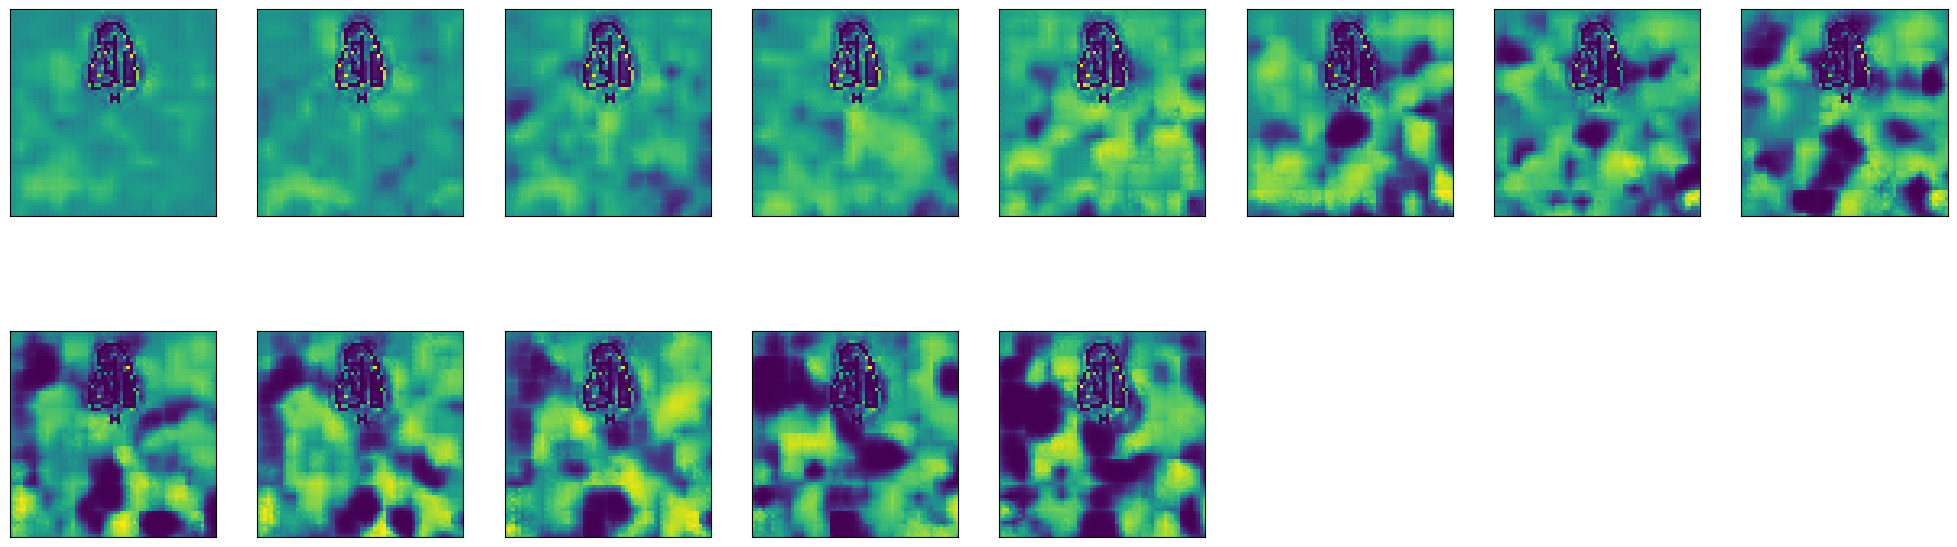

In [82]:
show_images(reconstructed_samples_full[n])

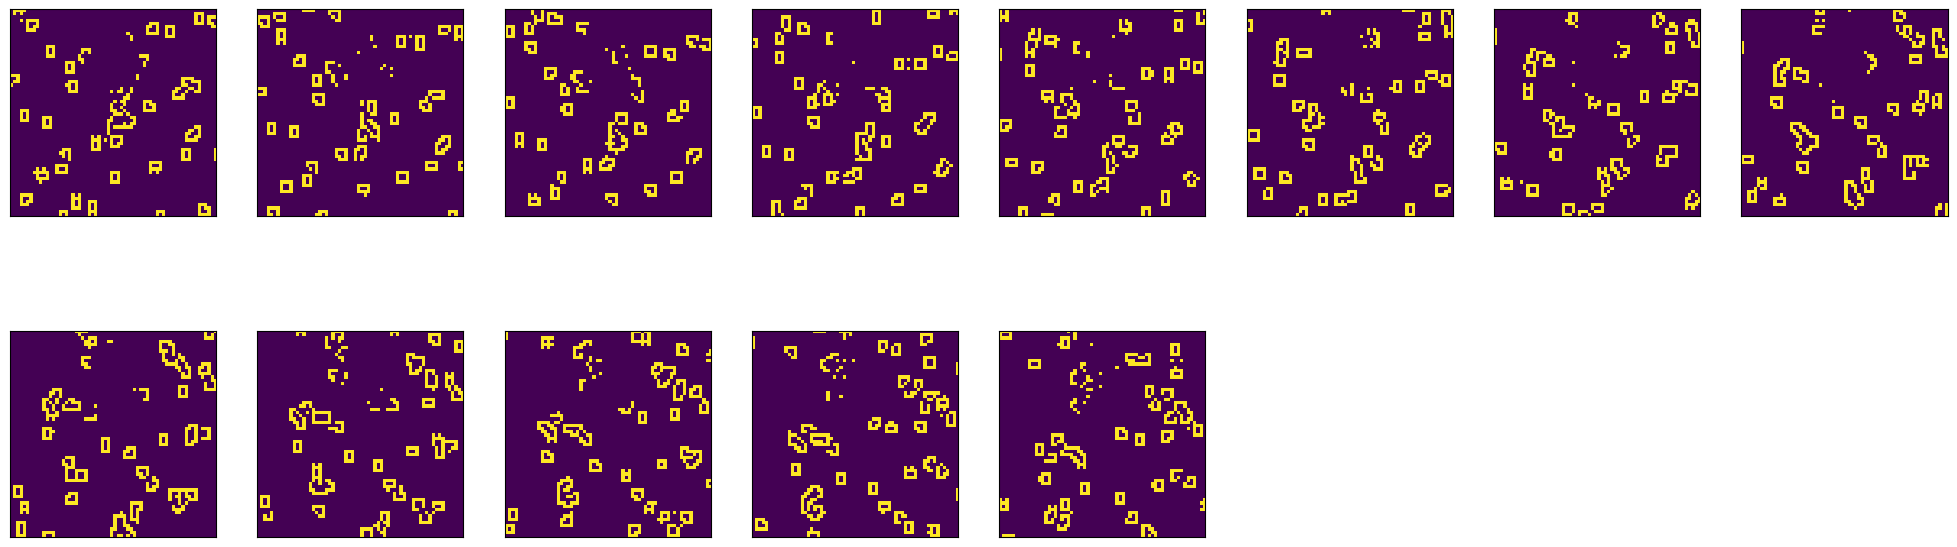

In [83]:
show_images(original_samples_full[n])

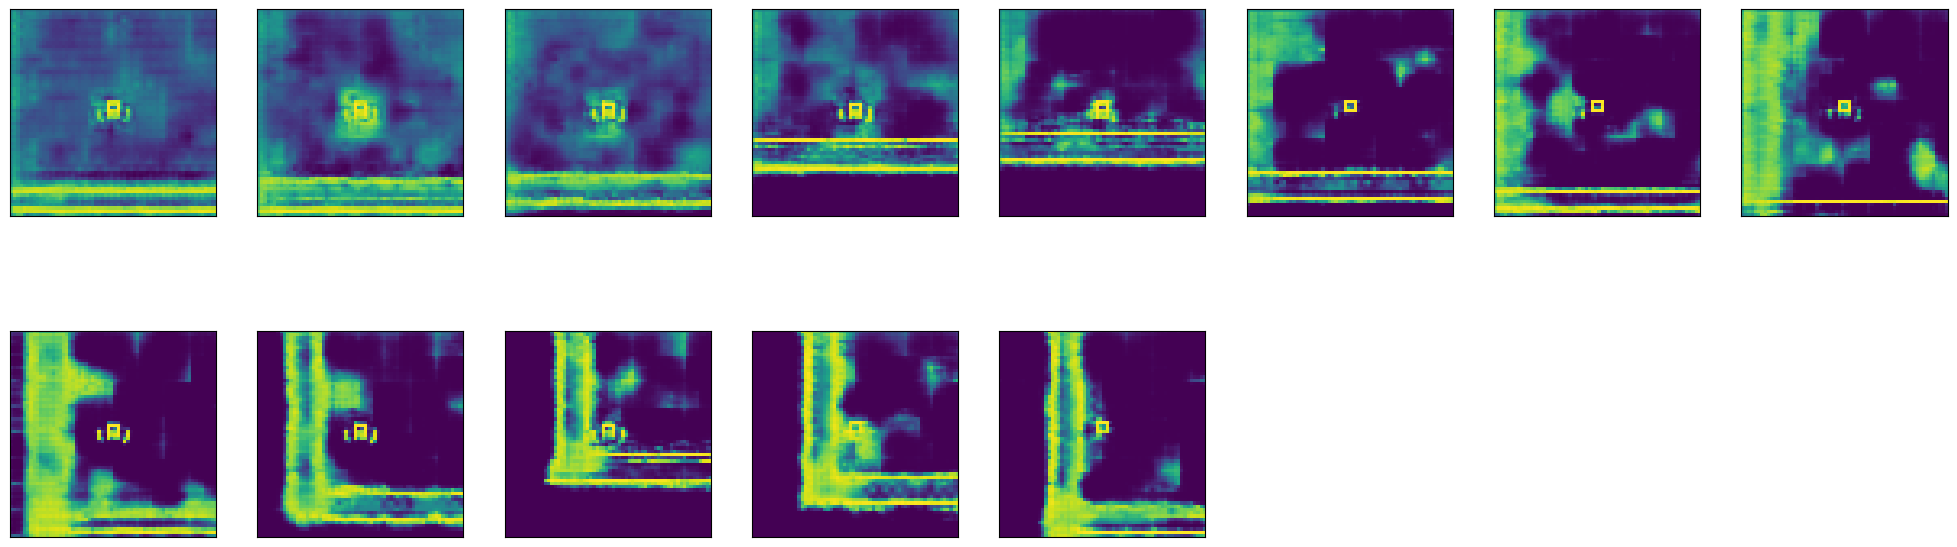

In [84]:
show_images(reconstructed_samples_part[n])

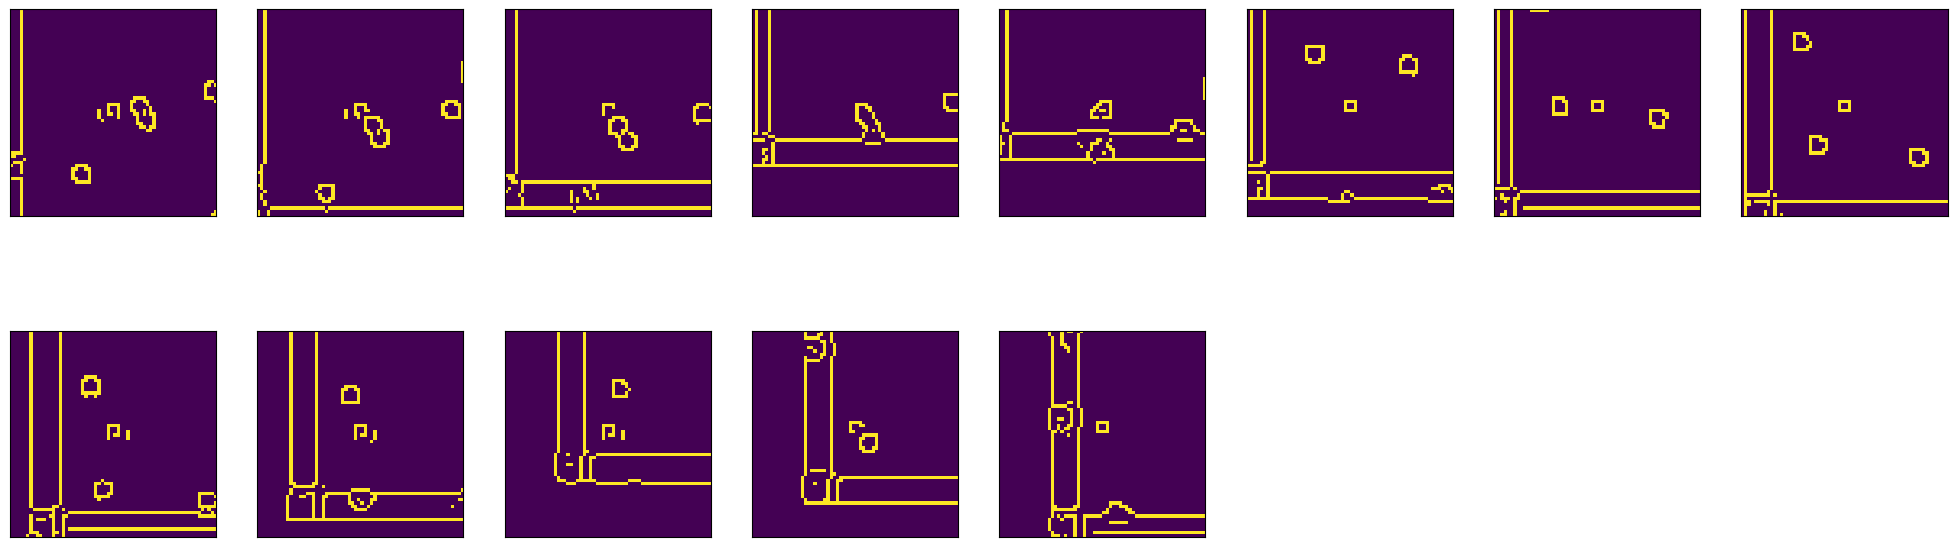

In [85]:
show_images(original_samples_part[n])

In [21]:
(decoder_debug(agent.posteriors_debug, agent.determenistics_debug).log_prob(pixel_normalization(torch.Tensor(sample)))/64/64).mean()

tensor(-46.9651, device='cuda:7', grad_fn=<MeanBackward0>)

In [27]:
obs_sample = dataset.observations[230:270,2]

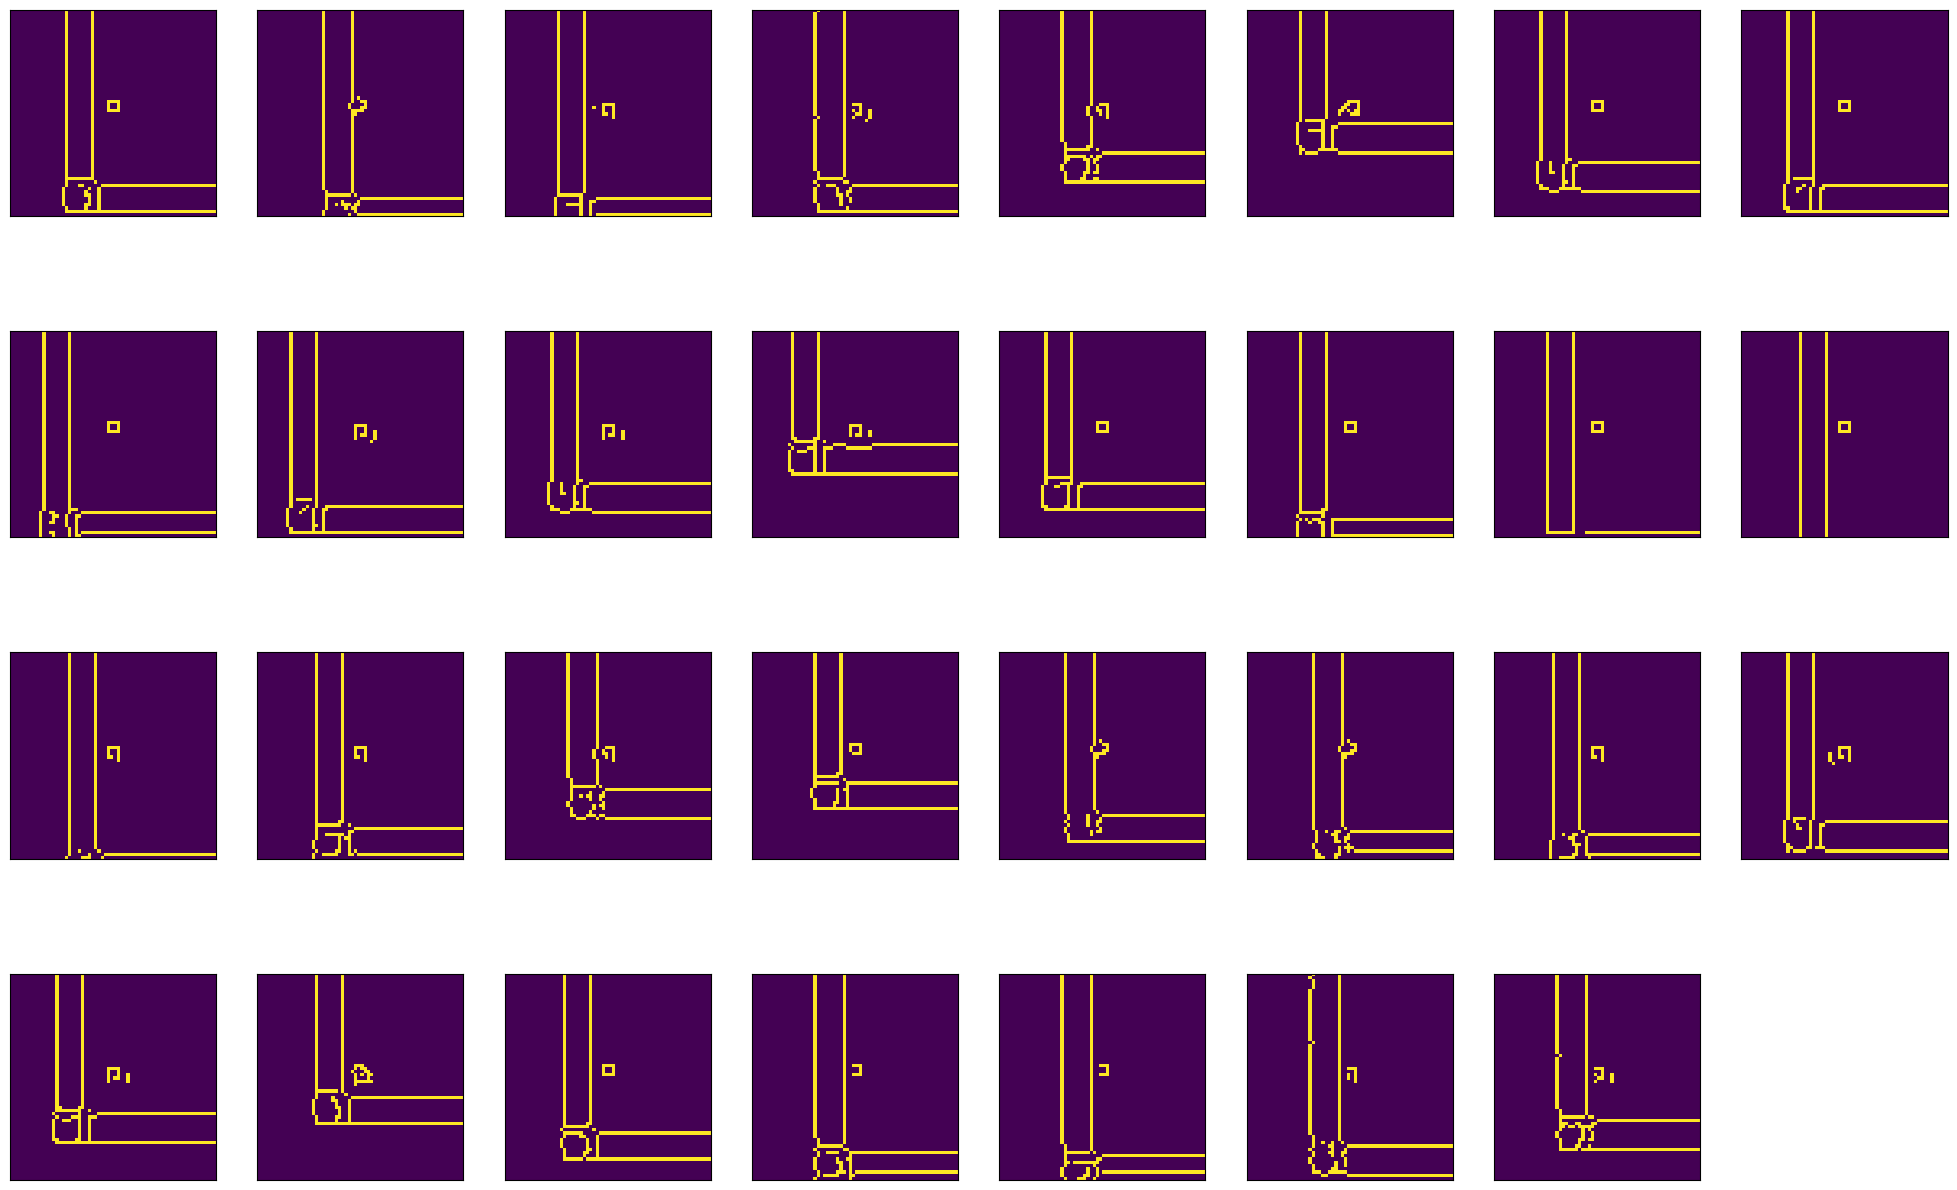

In [28]:
show_images(obs_sample)